(text:meta-explainers:surrogates:explanation-generation)=
# Explanation Generation #

In [1]:
# First, we need to set up the environment.

import sys
sys.path.insert(0, '../../../_code')

import fatf
import xml_book.data
import xml_book.models
import xml_book.surrogates

import fatf.utils.data.augmentation as fatf_augmentation

import fatf.utils.data.discretisation as fatf_discretisation
import fatf.utils.data.transformation as fatf_transformation

import fatf.utils.distances as fatf_distances
import fatf.utils.kernels as fatf_kernels

import fatf.utils.data.feature_selection.sklearn as fatf_feature_selection_skl

import sklearn.metrics.pairwise
import sklearn.tree

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display

22-Mar-21 18:34:27 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


This notebook combines insights from the *Interpretable Representations* and
*Data Sampling* exercises with the *Explanation Generation* step to build
local surrogate models.
It shows how to *weight data* and *achieve explanation sparsity* when
composing explanations of black-box predictions.
In particular, we discuss:
* a range of distance functions;
* kernels for transforming distances into similarity scores;
* (interpretable) feature selection mechanisms to introduce explanation sparsity;
* choice of surrogate model types; and
* types of explanations that can be generated, their meaning and interpretation.

We introduce these procedures for the *Two Moons* data set, which helps us
to convey the core concepts with visualisations.
Then, we move on to the more complicated example with the *Bikes Sharing* data
set.

## Toy Example -- Two Moons ##

### Loading the Data ###
First, we load the data.

In [2]:
moons_X, moons_X_test, moons_y, moons_y_test = xml_book.data.generate_2d_moons(
    random_seed=42)

22-Mar-21 18:34:28 fatf         INFO     Seeding RNGs using the input parameter.


22-Mar-21 18:34:28 fatf         INFO     Seeding RNGs with 42.


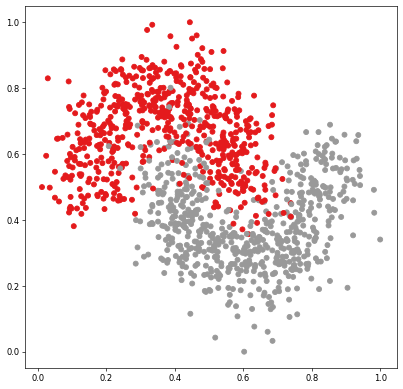

In [3]:
    # Plot data
plt.figure(figsize=(8, 8), dpi=60)
plt.scatter(moons_X[:, 0], moons_X[:, 1], cmap=plt.cm.Set1, c=moons_y)

### Loading the Black-Box Models ###
Next, we load our *crisp* and *probabilistic* black boxes.

In [4]:
clf_moons_proba = xml_book.models.get_random_forest(
    moons_X, moons_y, random_seed=42)

22-Mar-21 18:34:28 fatf         INFO     Seeding RNGs using the input parameter.


22-Mar-21 18:34:28 fatf         INFO     Seeding RNGs with 42.


In [5]:
clf_moons_crisp = xml_book.models.get_svc(
    moons_X, moons_y, random_seed=42)

22-Mar-21 18:34:28 fatf         INFO     Seeding RNGs using the input parameter.


22-Mar-21 18:34:28 fatf         INFO     Seeding RNGs with 42.


### Selecting an Instance to be Explained ###
For the Two Moons data set, we will generate explanations for a data point
close to a decision boundary.

In [6]:
moons_boundary_point = np.array([0.4, 0.6])

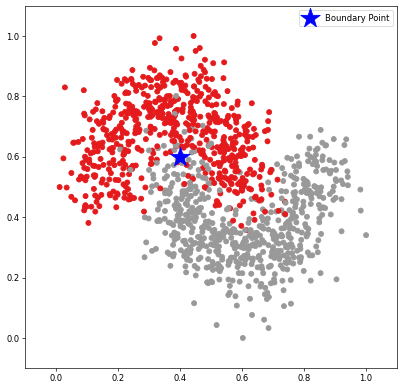

In [7]:
# Plot the points we are going to sample around
plt.figure(figsize=(8, 8), dpi=60)

plt.scatter(
    moons_X[:, 0], moons_X[:, 1],
    cmap=plt.cm.Set1, c=moons_y)

plt.scatter(
    moons_boundary_point[0], moons_boundary_point[1],
    marker='*', c='b', s=600, label='Boundary Point')

plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.legend()

### Sampling Data ###
Having seen how different samplers perform on this particular data set
(cf. `3-data-sampling.ipynb`), we opt for *Mixup* and we sample 250 data
points.
Also, we sample in the original data domain to avoid randomness entailed by
the "reverse sampling" step.

In [8]:
moons_mixup_sampler = fatf_augmentation.Mixup(
    moons_X_test, moons_y_test)

moons_samples_number = 250

In [9]:
moons_mixup_sample_close = moons_mixup_sampler.sample(
    moons_boundary_point,
    samples_number=moons_samples_number)

moons_mixup_sample_close_crisp = clf_moons_crisp.predict(
    moons_mixup_sample_close)

moons_mixup_sample_close_proba = clf_moons_proba.predict_proba(
    moons_mixup_sample_close)

Let's measure the diversity of our sample.

In [10]:
xml_book.surrogates.gini_index(moons_mixup_sample_close_crisp)

0.456192

(-0.1, 1.1)

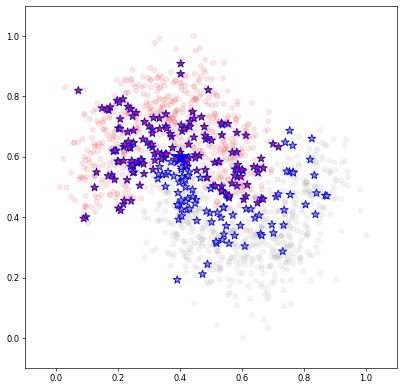

In [11]:
plt.figure(figsize=(8, 8), dpi=60)

plt.scatter(
    moons_X[:, 0], moons_X[:, 1],
    cmap=plt.cm.Set1, c=moons_y, alpha=0.1)

plt.scatter(
    moons_boundary_point[0], moons_boundary_point[1],
    marker='*', c='b', s=600, label='Boundary Point')

plt.scatter(
    moons_mixup_sample_close[:, 0], moons_mixup_sample_close[:, 1],
    marker='*', cmap=plt.cm.Set1, c=moons_mixup_sample_close_crisp,
    edgecolors='b', s=100)

plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)

### Building Interpretable Representation ###
Next, we compose two types of binary interpretable representations:
* binarised, quartile-based discretisation
  (it worked well for this particular data set); and
* one-hot encoded tree-based discretisation.

#### Quartile-based Interpretable Representation ####

In [12]:
q_discretiser_moons = fatf_discretisation.QuartileDiscretiser(moons_X_test)

Let's discretise the sample and the explained instance.

In [13]:
moons_mixup_sample_close_q_discrete = q_discretiser_moons.discretise(
    moons_mixup_sample_close)

In [14]:
moons_boundary_point_q_discrete = q_discretiser_moons.discretise(
    moons_boundary_point)

Now, we will binarise it.
(Recall that the binary representation of the explained instance is
an all-$1$ vector.)

In [15]:
moons_mixup_sample_close_q_binary = fatf_transformation.dataset_row_masking(
    moons_mixup_sample_close_q_discrete, moons_boundary_point_q_discrete)

In [16]:
moons_boundary_point_q_binary = np.ones_like(
    moons_boundary_point_q_discrete, dtype=np.int8)

Let's visualise these two steps.

/var/folders/d0/9mvcgn8503s6975cz1p09rmc0000gn/T/ipykernel_68128/2530916095.py:25: UserWarning: You passed a edgecolor/edgecolors ('b') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(moons_mixup_sample_close[indices, 0],


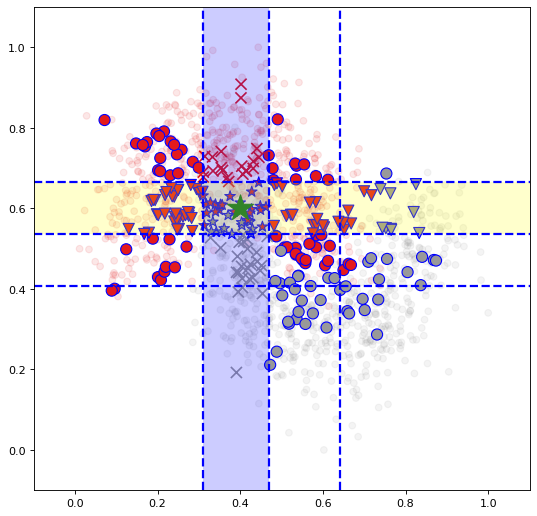

In [17]:
plt.figure(figsize=(8, 8), dpi=80)

plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)

plt.scatter(
    moons_X[:, 0], moons_X[:, 1],
    cmap=plt.cm.Set1, c=moons_y, alpha=0.1)

# Plot data using a unique marker for each binary encoding
moons_unique_binary = np.unique(moons_mixup_sample_close_q_binary, axis=0)
for rep in moons_unique_binary:
    indices = xml_book.surrogates.get_hyperrectangle_indices(
        moons_mixup_sample_close_q_binary, rep)

    if np.array_equal(rep, [1, 1]):
        marker = '*'
    elif np.array_equal(rep, [1, 0]):
        marker = 'x'
    elif np.array_equal(rep, [0, 1]):
        marker = 'v'
    else:
        marker = 'o'

    plt.scatter(moons_mixup_sample_close[indices, 0],
                moons_mixup_sample_close[indices, 1],
                c=moons_mixup_sample_close_crisp[indices],
                cmap=plt.cm.Set1,
                marker=marker,
                edgecolors='b',
                s=100)

# Plot explained instance
plt.scatter(
    moons_boundary_point[0], moons_boundary_point[1],
    marker='*', c='green', s=600, label='Boundary Point')

# Plot x-axis quartiles
x_quartiles_m = q_discretiser_moons.feature_bin_boundaries.get(0)
for i in x_quartiles_m:
    plt.plot([i, i], [-0.1, 1.1], linewidth=2, linestyle='--', c='blue')

# Plot y-axis quartiles
y_quartiles_m = q_discretiser_moons.feature_bin_boundaries.get(1)
for i in y_quartiles_m:
    plt.plot([-0.1, 1.1], [i, i], linewidth=2, linestyle='--', c='blue')

# Plot binarisation of the x-axis
hyper_rectangle_m_x = moons_boundary_point_q_discrete[0]
if 0 < hyper_rectangle_m_x < 3:
    hyper_rectangle_m_x_min = x_quartiles_m[hyper_rectangle_m_x - 1]
    hyper_rectangle_m_x_max = x_quartiles_m[hyper_rectangle_m_x]
elif hyper_rectangle_m_x == 0:
    hyper_rectangle_m_x_min = -0.1
    hyper_rectangle_m_x_max = x_quartiles_m[hyper_rectangle_m_x]
elif hyper_rectangle_m_x == 3:
    hyper_rectangle_m_x_min = x_quartiles_m[hyper_rectangle_m_x - 1]
    hyper_rectangle_m_x_max = 1.1
plt.axvspan(hyper_rectangle_m_x_min, hyper_rectangle_m_x_max,
            facecolor='blue', alpha=0.2)

# Plot binarisation of the y-axis
hyper_rectangle_m_y = moons_boundary_point_q_discrete[1]
if 0 < hyper_rectangle_m_y < 3:
    hyper_rectangle_m_y_min = y_quartiles_m[hyper_rectangle_m_y - 1]
    hyper_rectangle_m_y_max = y_quartiles_m[hyper_rectangle_m_y]
elif hyper_rectangle_m_y == 0:
    hyper_rectangle_m_y_min = -0.1
    hyper_rectangle_m_y_max = y_quartiles_m[hyper_rectangle_m_y]
elif hyper_rectangle_m_y == 3:
    hyper_rectangle_m_y_min = y_quartiles_m[hyper_rectangle_m_y - 1]
    hyper_rectangle_m_y_max = 1.1
plt.axhspan(hyper_rectangle_m_y_min, hyper_rectangle_m_y_max,
            facecolor='yellow', alpha=0.2)

In the plot above:
* colour encodes the class (red or grey) predicted by our crisp
  black-box model;
* blue dashed lines show quartile boundaries; and
* each marker shape encodes a unique binary representation:
  - $\star$ -- $(1,1)$,
  - $\times$ -- $(1, 0)$,
  - $\nabla$ -- $(0, 1)$, and
  - $\bullet$ -- $(0, 0)$.

Finally, let's measure purity of our discrete and binary representations.

In [18]:
xml_book.surrogates.weighted_purity(
    moons_mixup_sample_close_q_discrete,
    moons_mixup_sample_close_crisp,
    'gini')

0.1621015873015873

In [19]:
xml_book.surrogates.weighted_purity(
    moons_mixup_sample_close_q_binary,
    moons_mixup_sample_close_crisp,
    'gini')

0.4146381516237152

#### Tree-based Interpretable Representation ####
Let's move on to a tree-based interpretable representation.

In [20]:
tree_binariser_moons = sklearn.tree.DecisionTreeClassifier(
    random_state=42, max_leaf_nodes=4, min_impurity_decrease=0.05)
tree_binariser_moons.fit(moons_mixup_sample_close,
                         moons_mixup_sample_close_crisp)

DecisionTreeClassifier(max_leaf_nodes=4, min_impurity_decrease=0.05,
                       random_state=42)

First, we get the discrete...

In [21]:
moons_mixup_sample_close_tree_discrete = tree_binariser_moons.apply(
    moons_mixup_sample_close)
moons_boundary_point_tree_discrete = tree_binariser_moons.apply(
    [moons_boundary_point])[0]  # scikit-learn only accepts 2-D data

...then binary (one-hot encoded) representation.

In [22]:
moons_mixup_sample_close_tree_binary = xml_book.surrogates.one_hot_encode(
    moons_mixup_sample_close_tree_discrete)

The `xml_book.surrogates.one_hot_encode` function is incapable of handling a
single instance, therefore we have to process it manually.
To this end, we get all the unique IDs of our tree-based discretisation,
sort them, and get the index of the element that the discretisation
of the explained instance matches.

In [23]:
unique = np.sort(np.unique(moons_mixup_sample_close_tree_discrete))
mask = (unique == moons_boundary_point_tree_discrete)

moons_boundary_point_tree_binary = np.zeros(
    unique.shape[0], dtype=np.int8)
moons_boundary_point_tree_binary[mask] = 1

Let's visualise our tree-based partition.

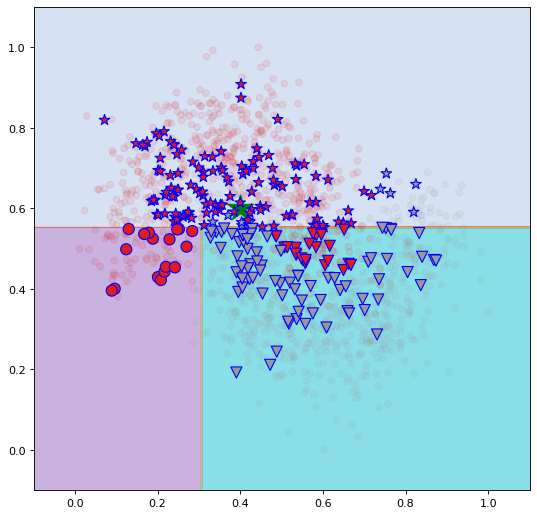

In [24]:
plt.figure(figsize=(8, 8), dpi=80)

plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)

# Compute the decision boundary of the tree
x_y_step = 0.005
x_min, x_max = -0.1, 1.1
y_min, y_max = -0.1, 1.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, x_y_step),
                     np.arange(y_min, y_max, x_y_step))

Z = tree_binariser_moons.apply(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
Z_norm = np.zeros_like(Z)
for i, v in enumerate(np.unique(Z)):
    mask = (Z == v)
    Z_norm[mask] = i

# Plot the boundary
plt.contourf(xx, yy, Z_norm, cmap=plt.cm.tab20, alpha=0.5)

# Plot data
plt.scatter(
    moons_X[:, 0], moons_X[:, 1],
    cmap=plt.cm.Set1, c=moons_y, alpha=0.1)

# Plot explained instance
plt.scatter(
    moons_boundary_point[0], moons_boundary_point[1],
    marker='*', c='green', s=600, label='Boundary Point')

# Plot data using a unique marker for each encoding
moons_unique_binary = np.unique(moons_mixup_sample_close_tree_discrete, axis=0)
markers = ['x', 'v', 'o']
for rep in moons_unique_binary:
    indices = xml_book.surrogates.get_hyperrectangle_indices(
        moons_mixup_sample_close_tree_discrete, rep)

    if np.array_equal(rep, moons_boundary_point_tree_discrete):
        marker = '*'
    else:
        marker = markers.pop()

    plt.scatter(moons_mixup_sample_close[indices, 0],
                moons_mixup_sample_close[indices, 1],
                c=moons_mixup_sample_close_crisp[indices],
                cmap=plt.cm.Set1,
                marker=marker,
                edgecolors='b',
                s=100)

And, finally, compute its purity.

In [25]:
xml_book.surrogates.weighted_purity(
    moons_mixup_sample_close_tree_discrete,
    moons_mixup_sample_close_crisp,
    'gini')

0.2207166591827571

### Explanation Generation ###
Now, we are ready to explain some black-box predictions.
In addition to *training a local surrogate model*, this procedure
may involve **weighting** the data sample and **reducing** the number
of interpretable features.

#### Data Weighting ####
To enforce the locality of an explanation even further (this has already
been achieved with a local data sample), we can weight the sampled data.
To this end, we need to compute the distance between the sample and the
explained instance, and kernelise these measures to transform them into
*similarity* scores.

We will compute and visualise three different distance metrics:
* Manhattan;
* Euclidean; and
* cosine.

We will investigate the effect of computing them in different representations:
* the original data domain;
* discrete representation; and
* binary representation.

Then, we will experiment with different parameterisations of the exponential
kernel:

$$\mathcal{K}(\mathbf{d}) = \sqrt{exp\left(-\frac{\mathbf{d}^2}{w^2}\right)}$$

setting $\mathbf{d}$ to:
* $1.00$,
* $0.10$ and
* $0.01$.

##### Original Data Domain #####
Let's start with the original data domain.

In [26]:
manhattan = sklearn.metrics.pairwise.manhattan_distances(
    [moons_boundary_point], moons_mixup_sample_close)[0]
euclidean = sklearn.metrics.pairwise.euclidean_distances(
    [moons_boundary_point], moons_mixup_sample_close)[0]
cosine = sklearn.metrics.pairwise.cosine_distances(
    [moons_boundary_point], moons_mixup_sample_close)[0]

/var/folders/d0/9mvcgn8503s6975cz1p09rmc0000gn/T/ipykernel_68128/398580212.py:85: UserWarning: You passed a edgecolor/edgecolors ('b') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[0].scatter(moons_mixup_sample_close[indices, 0],
/var/folders/d0/9mvcgn8503s6975cz1p09rmc0000gn/T/ipykernel_68128/398580212.py:94: UserWarning: You passed a edgecolor/edgecolors ('b') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[1].scatter(moons_mixup_sample_close[indices, 0],
/var/folders/d0/9mvcgn8503s6975cz1p09rmc0000gn/T/ipykernel_68128/398580212.py:103: UserWarning: You passed a edgecolor/edgecolors ('b') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[2].scatter(moons_mixup_sample_close[indices, 0],


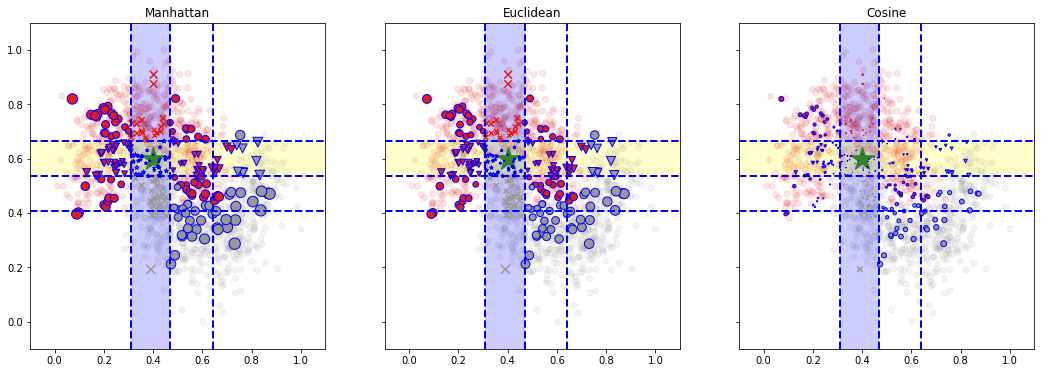

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

axs[0].set_xlim(-0.1, 1.1)
axs[0].set_ylim(-0.1, 1.1)

for a in range(3):
    axs[a].scatter(
        moons_X[:, 0], moons_X[:, 1],
        cmap=plt.cm.Set1, c=moons_y, alpha=0.1)

axs[0].set_title('Manhattan')
axs[1].set_title('Euclidean')
axs[2].set_title('Cosine')

# Plot explained instance
for a in range(3):
    axs[a].scatter(
        moons_boundary_point[0], moons_boundary_point[1],
        marker='*', c='green', s=600, label='Boundary Point')

# Plot x-axis quartiles
x_quartiles_m = q_discretiser_moons.feature_bin_boundaries.get(0)
for i in x_quartiles_m:
    for a in range(3):
        axs[a].plot([i, i], [-0.1, 1.1], linewidth=2, linestyle='--', c='blue')

# Plot y-axis quartiles
y_quartiles_m = q_discretiser_moons.feature_bin_boundaries.get(1)
for i in y_quartiles_m:
    for a in range(3):
        axs[a].plot([-0.1, 1.1], [i, i], linewidth=2, linestyle='--', c='blue')

# Plot binarisation of the x-axis
hyper_rectangle_m_x = moons_boundary_point_q_discrete[0]
if 0 < hyper_rectangle_m_x < 3:
    hyper_rectangle_m_x_min = x_quartiles_m[hyper_rectangle_m_x - 1]
    hyper_rectangle_m_x_max = x_quartiles_m[hyper_rectangle_m_x]
elif hyper_rectangle_m_x == 0:
    hyper_rectangle_m_x_min = -0.1
    hyper_rectangle_m_x_max = x_quartiles_m[hyper_rectangle_m_x]
elif hyper_rectangle_m_x == 3:
    hyper_rectangle_m_x_min = x_quartiles_m[hyper_rectangle_m_x - 1]
    hyper_rectangle_m_x_max = 1.1
for a in range(3):
    axs[a].axvspan(
        hyper_rectangle_m_x_min,
        hyper_rectangle_m_x_max,
        facecolor='blue',
        alpha=0.2)

# Plot binarisation of the y-axis
hyper_rectangle_m_y = moons_boundary_point_q_discrete[1]
if 0 < hyper_rectangle_m_y < 3:
    hyper_rectangle_m_y_min = y_quartiles_m[hyper_rectangle_m_y - 1]
    hyper_rectangle_m_y_max = y_quartiles_m[hyper_rectangle_m_y]
elif hyper_rectangle_m_y == 0:
    hyper_rectangle_m_y_min = -0.1
    hyper_rectangle_m_y_max = y_quartiles_m[hyper_rectangle_m_y]
elif hyper_rectangle_m_y == 3:
    hyper_rectangle_m_y_min = y_quartiles_m[hyper_rectangle_m_y - 1]
    hyper_rectangle_m_y_max = 1.1
for a in range(3):
    axs[a].axhspan(
        hyper_rectangle_m_y_min,
        hyper_rectangle_m_y_max,
        facecolor='yellow',
        alpha=0.2)

# Plot data using a unique marker for each binary encoding
moons_unique_binary = np.unique(moons_mixup_sample_close_q_binary, axis=0)
for rep in moons_unique_binary:
    indices = xml_book.surrogates.get_hyperrectangle_indices(
        moons_mixup_sample_close_q_binary, rep)

    if np.array_equal(rep, [1, 1]):
        marker = '*'
    elif np.array_equal(rep, [1, 0]):
        marker = 'x'
    elif np.array_equal(rep, [0, 1]):
        marker = 'v'
    else:
        marker = 'o'

    dist = manhattan[indices]
    axs[0].scatter(moons_mixup_sample_close[indices, 0],
                   moons_mixup_sample_close[indices, 1],
                   c=moons_mixup_sample_close_crisp[indices],
                   cmap=plt.cm.Set1,
                   marker=marker,
                   edgecolors='b',
                   s=200 * dist)

    dist = euclidean[indices]
    axs[1].scatter(moons_mixup_sample_close[indices, 0],
                   moons_mixup_sample_close[indices, 1],
                   c=moons_mixup_sample_close_crisp[indices],
                   cmap=plt.cm.Set1,
                   marker=marker,
                   edgecolors='b',
                   s=200 * dist)

    dist = cosine[indices]
    axs[2].scatter(moons_mixup_sample_close[indices, 0],
                   moons_mixup_sample_close[indices, 1],
                   c=moons_mixup_sample_close_crisp[indices],
                   cmap=plt.cm.Set1,
                   marker=marker,
                   edgecolors='b',
                   s=200 * dist)

Let's kernelise them using the exponential kernel.

In [28]:
manhattan_k_100 = fatf_kernels.exponential_kernel(
    manhattan, width=1)
manhattan_k_010 = fatf_kernels.exponential_kernel(
    manhattan, width=0.1)
manhattan_k_001 = fatf_kernels.exponential_kernel(
    manhattan, width=0.01)
manhattan_k = {
    '1': manhattan_k_100,
    '0.1': manhattan_k_010,
    '0.01': manhattan_k_001
}

euclidean_k_100 = fatf_kernels.exponential_kernel(
    euclidean, width=1)
euclidean_k_010 = fatf_kernels.exponential_kernel(
    euclidean, width=0.1)
euclidean_k_001 = fatf_kernels.exponential_kernel(
    euclidean, width=.01)
euclidean_k = {
    '1': euclidean_k_100,
    '0.1': euclidean_k_010,
    '0.01': euclidean_k_001
}

cosine_k_100 = fatf_kernels.exponential_kernel(
    cosine, width=1)
cosine_k_010 = fatf_kernels.exponential_kernel(
    cosine, width=0.1)
cosine_k_001 = fatf_kernels.exponential_kernel(
    cosine, width=.01)
cosine_k = {
    '1': cosine_k_100,
    '0.1': cosine_k_010,
    '0.01': cosine_k_001
}

names_k = ['1', '0.1', '0.01']

/var/folders/d0/9mvcgn8503s6975cz1p09rmc0000gn/T/ipykernel_68128/3304955845.py:90: UserWarning: You passed a edgecolor/edgecolors ('b') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ax, 0].scatter(
/var/folders/d0/9mvcgn8503s6975cz1p09rmc0000gn/T/ipykernel_68128/3304955845.py:101: UserWarning: You passed a edgecolor/edgecolors ('b') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ax, 1].scatter(
/var/folders/d0/9mvcgn8503s6975cz1p09rmc0000gn/T/ipykernel_68128/3304955845.py:112: UserWarning: You passed a edgecolor/edgecolors ('b') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ax, 2].scatter(


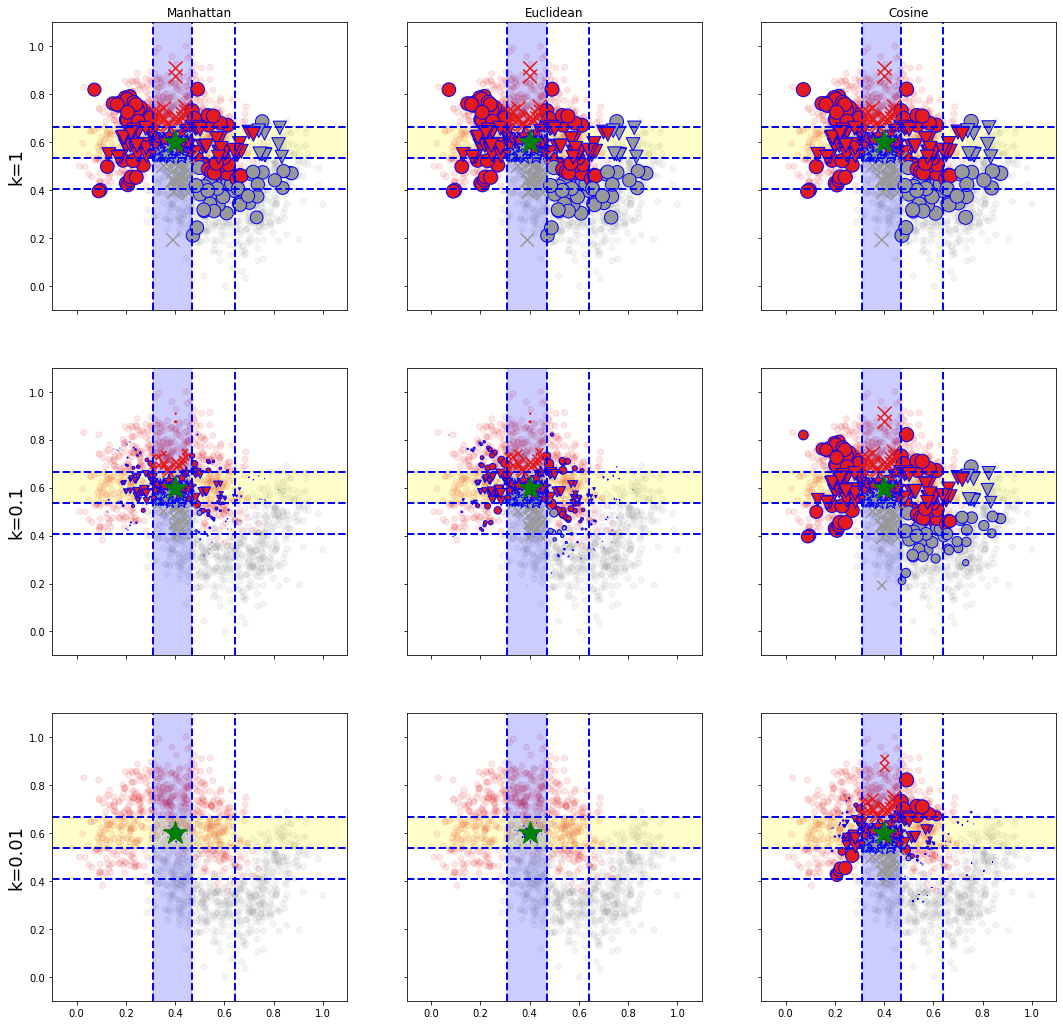

In [29]:
fig, axs = plt.subplots(3, 3, figsize=(18, 18), sharex=True, sharey=True)

axs[0, 0].set_xlim(-0.1, 1.1)
axs[0, 0].set_ylim(-0.1, 1.1)

for ax in range(3):
    for ay in range(3):
        axs[ax, ay].scatter(
            moons_X[:, 0], moons_X[:, 1],
            cmap=plt.cm.Set1, c=moons_y, alpha=0.1)

axs[0, 0].set_title('Manhattan')
axs[0, 1].set_title('Euclidean')
axs[0, 2].set_title('Cosine')

for ax, name in enumerate(names_k):
    axs[ax, 0].set_ylabel('k={}'.format(name), fontsize=18)

# Plot x-axis quartiles
x_quartiles_m = q_discretiser_moons.feature_bin_boundaries.get(0)
for i in x_quartiles_m:
    for ax in range(3):
        for ay in range(3):
            axs[ax, ay].plot(
                [i, i], [-0.1, 1.1], linewidth=2, linestyle='--', c='blue')

# Plot y-axis quartiles
y_quartiles_m = q_discretiser_moons.feature_bin_boundaries.get(1)
for i in y_quartiles_m:
    for ax in range(3):
        for ay in range(3):
            axs[ax, ay].plot(
                [-0.1, 1.1], [i, i], linewidth=2, linestyle='--', c='blue')

# Plot binarisation of the x-axis
hyper_rectangle_m_x = moons_boundary_point_q_discrete[0]
if 0 < hyper_rectangle_m_x < 3:
    hyper_rectangle_m_x_min = x_quartiles_m[hyper_rectangle_m_x - 1]
    hyper_rectangle_m_x_max = x_quartiles_m[hyper_rectangle_m_x]
elif hyper_rectangle_m_x == 0:
    hyper_rectangle_m_x_min = -0.1
    hyper_rectangle_m_x_max = x_quartiles_m[hyper_rectangle_m_x]
elif hyper_rectangle_m_x == 3:
    hyper_rectangle_m_x_min = x_quartiles_m[hyper_rectangle_m_x - 1]
    hyper_rectangle_m_x_max = 1.1
for ax in range(3):
    for ay in range(3):
        axs[ax, ay].axvspan(
            hyper_rectangle_m_x_min,
            hyper_rectangle_m_x_max,
            facecolor='blue',
            alpha=0.2)

# Plot binarisation of the y-axis
hyper_rectangle_m_y = moons_boundary_point_q_discrete[1]
if 0 < hyper_rectangle_m_y < 3:
    hyper_rectangle_m_y_min = y_quartiles_m[hyper_rectangle_m_y - 1]
    hyper_rectangle_m_y_max = y_quartiles_m[hyper_rectangle_m_y]
elif hyper_rectangle_m_y == 0:
    hyper_rectangle_m_y_min = -0.1
    hyper_rectangle_m_y_max = y_quartiles_m[hyper_rectangle_m_y]
elif hyper_rectangle_m_y == 3:
    hyper_rectangle_m_y_min = y_quartiles_m[hyper_rectangle_m_y - 1]
    hyper_rectangle_m_y_max = 1.1
for ax in range(3):
    for ay in range(3):
        axs[ax, ay].axhspan(
            hyper_rectangle_m_y_min,
            hyper_rectangle_m_y_max,
            facecolor='yellow',
            alpha=0.2)

# Plot data using a unique marker for each binary encoding
moons_unique_binary = np.unique(moons_mixup_sample_close_q_binary, axis=0)
for rep in moons_unique_binary:
    indices = xml_book.surrogates.get_hyperrectangle_indices(
        moons_mixup_sample_close_q_binary, rep)

    if np.array_equal(rep, [1, 1]):
        marker = '*'
    elif np.array_equal(rep, [1, 0]):
        marker = 'x'
    elif np.array_equal(rep, [0, 1]):
        marker = 'v'
    else:
        marker = 'o'

    for ax, k in enumerate(names_k):
        sim = manhattan_k[k][indices]
        axs[ax, 0].scatter(
            moons_mixup_sample_close[indices, 0],
            moons_mixup_sample_close[indices, 1],
            c=moons_mixup_sample_close_crisp[indices],
            cmap=plt.cm.Set1,
            marker=marker,
            edgecolors='b',
            s=200 * sim)

    for ax, k in enumerate(names_k):
        sim = euclidean_k[k][indices]
        axs[ax, 1].scatter(
            moons_mixup_sample_close[indices, 0],
            moons_mixup_sample_close[indices, 1],
            c=moons_mixup_sample_close_crisp[indices],
            cmap=plt.cm.Set1,
            marker=marker,
            edgecolors='b',
            s=200 * sim)

    for ax, k in enumerate(names_k):
        sim = cosine_k[k][indices]
        axs[ax, 2].scatter(
            moons_mixup_sample_close[indices, 0],
            moons_mixup_sample_close[indices, 1],
            c=moons_mixup_sample_close_crisp[indices],
            cmap=plt.cm.Set1,
            marker=marker,
            edgecolors='b',
            s=200 * sim)

# Plot explained instance
for ax in range(3):
    for ay in range(3):
        axs[ax, ay].scatter(
            moons_boundary_point[0], moons_boundary_point[1],
            marker='*', c='green', s=600, label='Boundary Point')

As you can see, the **distance type** and **kernel parameterisation**
have quite strong influence on importance of the instances when fitting
a local surrogate model.
Keep in mind that these weights could have been used to discretise the data
in the first place -- we will see such an effect for tree-learnt interpretable
representation.

---

Now, let's investigate how these weights influence the discretisation produced
by a tree.
Note that this can only be done for weights computed in the original data
domain.

This behaviour is introduced by the `sample_weight` parameter to the
`DecisionTreeClassifier`'s `fit` method, e.g.:
``` Python
tree = sklearn.tree.DecisionTreeClassifier()
tree.fit(data, labels, sample_weight=weights)
```

/var/folders/d0/9mvcgn8503s6975cz1p09rmc0000gn/T/ipykernel_68128/3162818415.py:62: UserWarning: You passed a edgecolor/edgecolors ('b') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ax, ay].scatter(


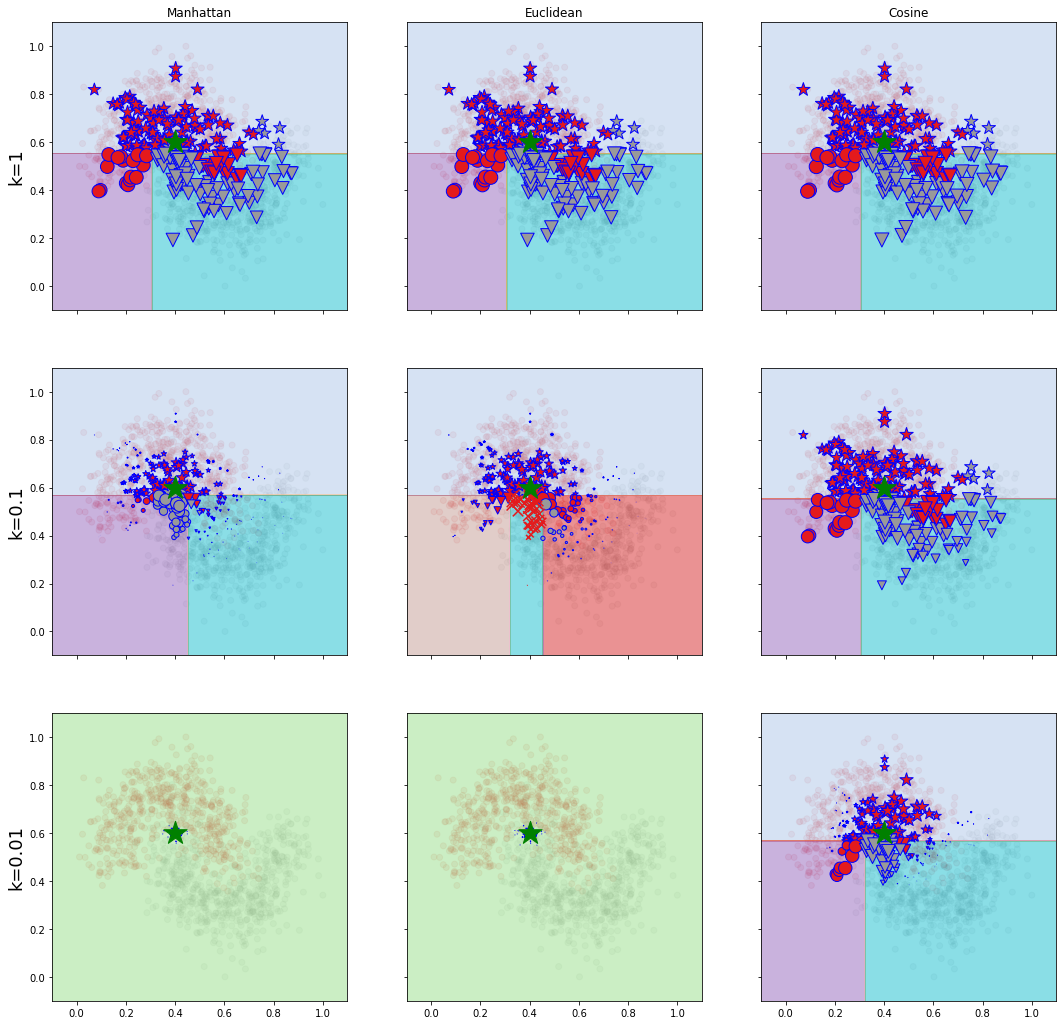

In [30]:
# Compute the decision boundary of the tree
x_y_step = 0.005
x_min, x_max = -0.1, 1.1
y_min, y_max = -0.1, 1.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, x_y_step),
                     np.arange(y_min, y_max, x_y_step))

fig, axs = plt.subplots(3, 3, figsize=(18, 18), sharex=True, sharey=True)

axs[0, 0].set_xlim(-0.1, 1.1)
axs[0, 0].set_ylim(-0.1, 1.1)

for ax in range(3):
    for ay in range(3):
        axs[ax, ay].scatter(
            moons_X[:, 0], moons_X[:, 1],
            cmap=plt.cm.Set1, c=moons_y, alpha=0.1)

axs[0, 0].set_title('Manhattan')
axs[0, 1].set_title('Euclidean')
axs[0, 2].set_title('Cosine')

for ax, name in enumerate(names_k):
    axs[ax, 0].set_ylabel('k={}'.format(name), fontsize=18)

# Plot data using a unique marker for each binary encoding
for ay, w in enumerate([manhattan_k, euclidean_k, cosine_k]):
    for ax, k in enumerate(names_k):
        tree_binariser_ = sklearn.tree.DecisionTreeClassifier(
            random_state=42, max_leaf_nodes=4, min_impurity_decrease=0.05)
        tree_binariser_.fit(moons_mixup_sample_close,
                            moons_mixup_sample_close_crisp,
                            sample_weight=w[k])
        discretised_sample = tree_binariser_.apply(moons_mixup_sample_close)
        discretised_explained = tree_binariser_.apply(
            [moons_boundary_point])[0]

        # Plot the boundary
        Z = tree_binariser_.apply(np.c_[xx.ravel(), yy.ravel()])
        
        Z = Z.reshape(xx.shape)
        Z_norm = np.zeros_like(Z)
        for i, v in enumerate(np.unique(Z)):
            mask = (Z == v)
            Z_norm[mask] = i
        
        axs[ax, ay].contourf(xx, yy, Z_norm, cmap=plt.cm.tab20, alpha=0.5)

        # Plot data using a unique marker for each encoding
        moons_unique_binary = np.unique(discretised_sample, axis=0)
        markers = ['x', 'v', 'o']
        for rep in moons_unique_binary:
            indices = xml_book.surrogates.get_hyperrectangle_indices(
                discretised_sample, rep)
        
            if np.array_equal(rep, discretised_explained):
                marker = '*'
            else:
                marker = markers.pop()
        
            sim = w[k][indices]
            axs[ax, ay].scatter(
                moons_mixup_sample_close[indices, 0],
                moons_mixup_sample_close[indices, 1],
                c=moons_mixup_sample_close_crisp[indices],
                cmap=plt.cm.Set1,
                marker=marker,
                edgecolors='b',
                s=200 * sim)

# Plot explained instance
for ax in range(3):
    for ay in range(3):
        axs[ax, ay].scatter(
            moons_boundary_point[0], moons_boundary_point[1],
            marker='*', c='green', s=600, label='Boundary Point')

The green shading indicates trees with no splits, i.e.,
they predict the majority class according to the weighted
data sample.
Again, the effect is quite pronounced.

##### Discretised Data Domain #####
Now, let's repeat the procedure for distances and weights computed in the discrete
domain based on quartiles.

In [31]:
manhattan = sklearn.metrics.pairwise.manhattan_distances(
    [moons_boundary_point_q_discrete], moons_mixup_sample_close_q_discrete)[0]
euclidean = sklearn.metrics.pairwise.euclidean_distances(
    [moons_boundary_point_q_discrete], moons_mixup_sample_close_q_discrete)[0]
cosine = sklearn.metrics.pairwise.cosine_distances(
    [moons_boundary_point_q_discrete], moons_mixup_sample_close_q_discrete)[0]

/var/folders/d0/9mvcgn8503s6975cz1p09rmc0000gn/T/ipykernel_68128/2879942533.py:85: UserWarning: You passed a edgecolor/edgecolors ('b') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[0].scatter(moons_mixup_sample_close[indices, 0],
/var/folders/d0/9mvcgn8503s6975cz1p09rmc0000gn/T/ipykernel_68128/2879942533.py:94: UserWarning: You passed a edgecolor/edgecolors ('b') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[1].scatter(moons_mixup_sample_close[indices, 0],
/var/folders/d0/9mvcgn8503s6975cz1p09rmc0000gn/T/ipykernel_68128/2879942533.py:103: UserWarning: You passed a edgecolor/edgecolors ('b') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[2].scatter(moons_mixup_sample_close[indices, 0],


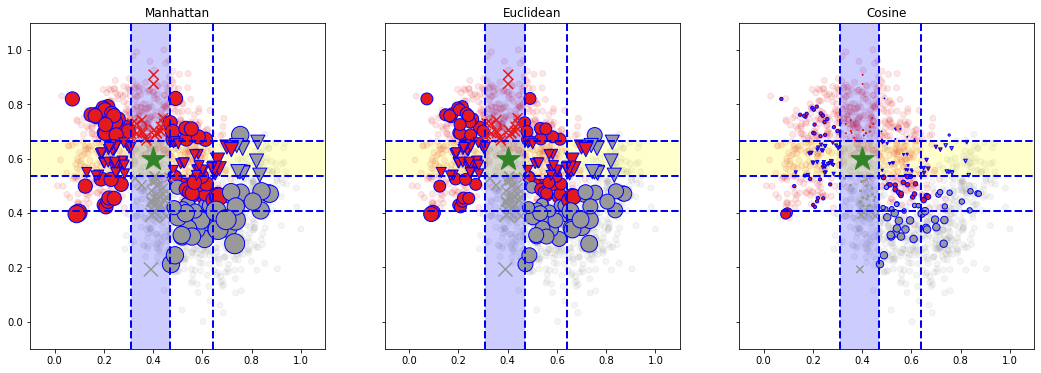

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

axs[0].set_xlim(-0.1, 1.1)
axs[0].set_ylim(-0.1, 1.1)

for ax in range(3):
    axs[ax].scatter(
        moons_X[:, 0], moons_X[:, 1],
        cmap=plt.cm.Set1, c=moons_y, alpha=0.1)

axs[0].set_title('Manhattan')
axs[1].set_title('Euclidean')
axs[2].set_title('Cosine')

# Plot explained instance
for ax in range(3):
    axs[ax].scatter(
        moons_boundary_point[0], moons_boundary_point[1],
        marker='*', c='green', s=600, label='Boundary Point')

# Plot x-axis quartiles
x_quartiles_m = q_discretiser_moons.feature_bin_boundaries.get(0)
for i in x_quartiles_m:
    for ax in range(3):
        axs[ax].plot([i, i], [-0.1, 1.1], linewidth=2, linestyle='--', c='blue')

# Plot y-axis quartiles
y_quartiles_m = q_discretiser_moons.feature_bin_boundaries.get(1)
for i in y_quartiles_m:
    for ax in range(3):
        axs[ax].plot([-0.1, 1.1], [i, i], linewidth=2, linestyle='--', c='blue')

# Plot binarisation of the x-axis
hyper_rectangle_m_x = moons_boundary_point_q_discrete[0]
if 0 < hyper_rectangle_m_x < 3:
    hyper_rectangle_m_x_min = x_quartiles_m[hyper_rectangle_m_x - 1]
    hyper_rectangle_m_x_max = x_quartiles_m[hyper_rectangle_m_x]
elif hyper_rectangle_m_x == 0:
    hyper_rectangle_m_x_min = -0.1
    hyper_rectangle_m_x_max = x_quartiles_m[hyper_rectangle_m_x]
elif hyper_rectangle_m_x == 3:
    hyper_rectangle_m_x_min = x_quartiles_m[hyper_rectangle_m_x - 1]
    hyper_rectangle_m_x_max = 1.1
for ax in range(3):
    axs[ax].axvspan(
        hyper_rectangle_m_x_min,
        hyper_rectangle_m_x_max,
        facecolor='blue',
        alpha=0.2)

# Plot binarisation of the y-axis
hyper_rectangle_m_y = moons_boundary_point_q_discrete[1]
if 0 < hyper_rectangle_m_y < 3:
    hyper_rectangle_m_y_min = y_quartiles_m[hyper_rectangle_m_y - 1]
    hyper_rectangle_m_y_max = y_quartiles_m[hyper_rectangle_m_y]
elif hyper_rectangle_m_y == 0:
    hyper_rectangle_m_y_min = -0.1
    hyper_rectangle_m_y_max = y_quartiles_m[hyper_rectangle_m_y]
elif hyper_rectangle_m_y == 3:
    hyper_rectangle_m_y_min = y_quartiles_m[hyper_rectangle_m_y - 1]
    hyper_rectangle_m_y_max = 1.1
for ax in range(3):
    axs[ax].axhspan(
        hyper_rectangle_m_y_min,
        hyper_rectangle_m_y_max,
        facecolor='yellow',
        alpha=0.2)

# Plot data using a unique marker for each binary encoding
moons_unique_binary = np.unique(moons_mixup_sample_close_q_binary, axis=0)
for rep in moons_unique_binary:
    indices = xml_book.surrogates.get_hyperrectangle_indices(
        moons_mixup_sample_close_q_binary, rep)

    if np.array_equal(rep, [1, 1]):
        marker = '*'
    elif np.array_equal(rep, [1, 0]):
        marker = 'x'
    elif np.array_equal(rep, [0, 1]):
        marker = 'v'
    else:
        marker = 'o'

    dist = manhattan[indices]
    axs[0].scatter(moons_mixup_sample_close[indices, 0],
                   moons_mixup_sample_close[indices, 1],
                   c=moons_mixup_sample_close_crisp[indices],
                   cmap=plt.cm.Set1,
                   marker=marker,
                   edgecolors='b',
                   s=100 * dist)

    dist = euclidean[indices]
    axs[1].scatter(moons_mixup_sample_close[indices, 0],
                   moons_mixup_sample_close[indices, 1],
                   c=moons_mixup_sample_close_crisp[indices],
                   cmap=plt.cm.Set1,
                   marker=marker,
                   edgecolors='b',
                   s=100 * dist)

    dist = cosine[indices]
    axs[2].scatter(moons_mixup_sample_close[indices, 0],
                   moons_mixup_sample_close[indices, 1],
                   c=moons_mixup_sample_close_crisp[indices],
                   cmap=plt.cm.Set1,
                   marker=marker,
                   edgecolors='b',
                   s=100 * dist)

Since we are using the discrete space (hyper-rectangles) to compute distances,
all of the points within a single partition have the same distance from
the explained instance.
The ones in the explained hyper-rectangle have distance $0$, hence they are not
plotted.
Let's kernelise these distances.

In [33]:
manhattan_k_100 = fatf_kernels.exponential_kernel(
    manhattan, width=1)
manhattan_k_010 = fatf_kernels.exponential_kernel(
    manhattan, width=0.1)
manhattan_k_001 = fatf_kernels.exponential_kernel(
    manhattan, width=0.01)
manhattan_k = {
    '1': manhattan_k_100,
    '0.1': manhattan_k_010,
    '0.01': manhattan_k_001
}

euclidean_k_100 = fatf_kernels.exponential_kernel(
    euclidean, width=1)
euclidean_k_010 = fatf_kernels.exponential_kernel(
    euclidean, width=0.1)
euclidean_k_001 = fatf_kernels.exponential_kernel(
    euclidean, width=.01)
euclidean_k = {
    '1': euclidean_k_100,
    '0.1': euclidean_k_010,
    '0.01': euclidean_k_001
}

cosine_k_100 = fatf_kernels.exponential_kernel(
    cosine, width=1)
cosine_k_010 = fatf_kernels.exponential_kernel(
    cosine, width=0.1)
cosine_k_001 = fatf_kernels.exponential_kernel(
    cosine, width=.01)
cosine_k = {
    '1': cosine_k_100,
    '0.1': cosine_k_010,
    '0.01': cosine_k_001
}

names_k = ['1', '0.1', '0.01']

/var/folders/d0/9mvcgn8503s6975cz1p09rmc0000gn/T/ipykernel_68128/3304955845.py:90: UserWarning: You passed a edgecolor/edgecolors ('b') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ax, 0].scatter(
/var/folders/d0/9mvcgn8503s6975cz1p09rmc0000gn/T/ipykernel_68128/3304955845.py:101: UserWarning: You passed a edgecolor/edgecolors ('b') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ax, 1].scatter(
/var/folders/d0/9mvcgn8503s6975cz1p09rmc0000gn/T/ipykernel_68128/3304955845.py:112: UserWarning: You passed a edgecolor/edgecolors ('b') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ax, 2].scatter(


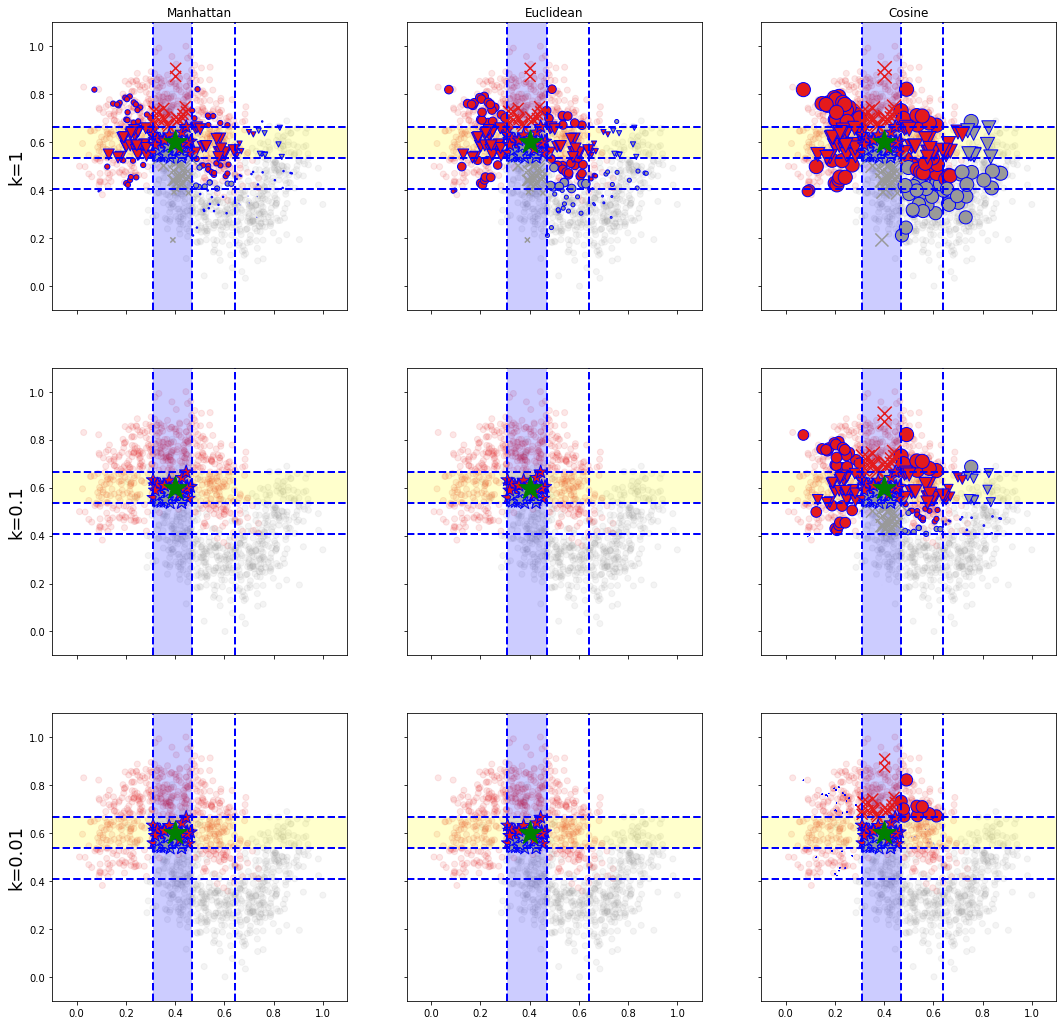

In [34]:
fig, axs = plt.subplots(3, 3, figsize=(18, 18), sharex=True, sharey=True)

axs[0, 0].set_xlim(-0.1, 1.1)
axs[0, 0].set_ylim(-0.1, 1.1)

for ax in range(3):
    for ay in range(3):
        axs[ax, ay].scatter(
            moons_X[:, 0], moons_X[:, 1],
            cmap=plt.cm.Set1, c=moons_y, alpha=0.1)

axs[0, 0].set_title('Manhattan')
axs[0, 1].set_title('Euclidean')
axs[0, 2].set_title('Cosine')

for ax, name in enumerate(names_k):
    axs[ax, 0].set_ylabel('k={}'.format(name), fontsize=18)

# Plot x-axis quartiles
x_quartiles_m = q_discretiser_moons.feature_bin_boundaries.get(0)
for i in x_quartiles_m:
    for ax in range(3):
        for ay in range(3):
            axs[ax, ay].plot(
                [i, i], [-0.1, 1.1], linewidth=2, linestyle='--', c='blue')

# Plot y-axis quartiles
y_quartiles_m = q_discretiser_moons.feature_bin_boundaries.get(1)
for i in y_quartiles_m:
    for ax in range(3):
        for ay in range(3):
            axs[ax, ay].plot(
                [-0.1, 1.1], [i, i], linewidth=2, linestyle='--', c='blue')

# Plot binarisation of the x-axis
hyper_rectangle_m_x = moons_boundary_point_q_discrete[0]
if 0 < hyper_rectangle_m_x < 3:
    hyper_rectangle_m_x_min = x_quartiles_m[hyper_rectangle_m_x - 1]
    hyper_rectangle_m_x_max = x_quartiles_m[hyper_rectangle_m_x]
elif hyper_rectangle_m_x == 0:
    hyper_rectangle_m_x_min = -0.1
    hyper_rectangle_m_x_max = x_quartiles_m[hyper_rectangle_m_x]
elif hyper_rectangle_m_x == 3:
    hyper_rectangle_m_x_min = x_quartiles_m[hyper_rectangle_m_x - 1]
    hyper_rectangle_m_x_max = 1.1
for ax in range(3):
    for ay in range(3):
        axs[ax, ay].axvspan(
            hyper_rectangle_m_x_min,
            hyper_rectangle_m_x_max,
            facecolor='blue',
            alpha=0.2)

# Plot binarisation of the y-axis
hyper_rectangle_m_y = moons_boundary_point_q_discrete[1]
if 0 < hyper_rectangle_m_y < 3:
    hyper_rectangle_m_y_min = y_quartiles_m[hyper_rectangle_m_y - 1]
    hyper_rectangle_m_y_max = y_quartiles_m[hyper_rectangle_m_y]
elif hyper_rectangle_m_y == 0:
    hyper_rectangle_m_y_min = -0.1
    hyper_rectangle_m_y_max = y_quartiles_m[hyper_rectangle_m_y]
elif hyper_rectangle_m_y == 3:
    hyper_rectangle_m_y_min = y_quartiles_m[hyper_rectangle_m_y - 1]
    hyper_rectangle_m_y_max = 1.1
for ax in range(3):
    for ay in range(3):
        axs[ax, ay].axhspan(
            hyper_rectangle_m_y_min,
            hyper_rectangle_m_y_max,
            facecolor='yellow',
            alpha=0.2)

# Plot data using a unique marker for each binary encoding
moons_unique_binary = np.unique(moons_mixup_sample_close_q_binary, axis=0)
for rep in moons_unique_binary:
    indices = xml_book.surrogates.get_hyperrectangle_indices(
        moons_mixup_sample_close_q_binary, rep)

    if np.array_equal(rep, [1, 1]):
        marker = '*'
    elif np.array_equal(rep, [1, 0]):
        marker = 'x'
    elif np.array_equal(rep, [0, 1]):
        marker = 'v'
    else:
        marker = 'o'

    for ax, k in enumerate(names_k):
        sim = manhattan_k[k][indices]
        axs[ax, 0].scatter(
            moons_mixup_sample_close[indices, 0],
            moons_mixup_sample_close[indices, 1],
            c=moons_mixup_sample_close_crisp[indices],
            cmap=plt.cm.Set1,
            marker=marker,
            edgecolors='b',
            s=200 * sim)

    for ax, k in enumerate(names_k):
        sim = euclidean_k[k][indices]
        axs[ax, 1].scatter(
            moons_mixup_sample_close[indices, 0],
            moons_mixup_sample_close[indices, 1],
            c=moons_mixup_sample_close_crisp[indices],
            cmap=plt.cm.Set1,
            marker=marker,
            edgecolors='b',
            s=200 * sim)

    for ax, k in enumerate(names_k):
        sim = cosine_k[k][indices]
        axs[ax, 2].scatter(
            moons_mixup_sample_close[indices, 0],
            moons_mixup_sample_close[indices, 1],
            c=moons_mixup_sample_close_crisp[indices],
            cmap=plt.cm.Set1,
            marker=marker,
            edgecolors='b',
            s=200 * sim)

# Plot explained instance
for ax in range(3):
    for ay in range(3):
        axs[ax, ay].scatter(
            moons_boundary_point[0], moons_boundary_point[1],
            marker='*', c='green', s=600, label='Boundary Point')

Weighting in the discrete domain shows quite a peculiar behaviour which may,
or may not, be desired.

##### Binarised Data Domain #####
Finally, let's do the same for distances and weights computed in the binary
domain based on quartiles.

In [35]:
manhattan = sklearn.metrics.pairwise.manhattan_distances(
    [moons_boundary_point_q_binary], moons_mixup_sample_close_q_binary)[0]
euclidean = sklearn.metrics.pairwise.euclidean_distances(
    [moons_boundary_point_q_binary], moons_mixup_sample_close_q_binary)[0]
cosine = sklearn.metrics.pairwise.cosine_distances(
    [moons_boundary_point_q_binary], moons_mixup_sample_close_q_binary)[0]

/var/folders/d0/9mvcgn8503s6975cz1p09rmc0000gn/T/ipykernel_68128/2879942533.py:85: UserWarning: You passed a edgecolor/edgecolors ('b') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[0].scatter(moons_mixup_sample_close[indices, 0],
/var/folders/d0/9mvcgn8503s6975cz1p09rmc0000gn/T/ipykernel_68128/2879942533.py:94: UserWarning: You passed a edgecolor/edgecolors ('b') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[1].scatter(moons_mixup_sample_close[indices, 0],
/var/folders/d0/9mvcgn8503s6975cz1p09rmc0000gn/T/ipykernel_68128/2879942533.py:103: UserWarning: You passed a edgecolor/edgecolors ('b') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[2].scatter(moons_mixup_sample_close[indices, 0],


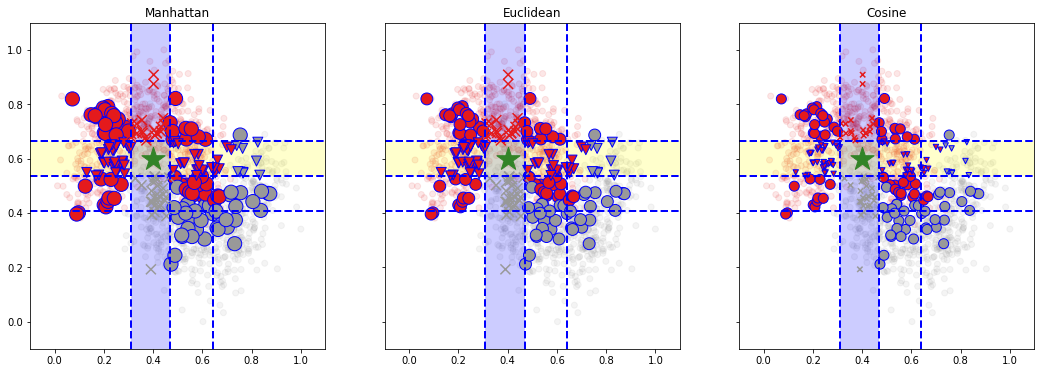

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

axs[0].set_xlim(-0.1, 1.1)
axs[0].set_ylim(-0.1, 1.1)

for ax in range(3):
    axs[ax].scatter(
        moons_X[:, 0], moons_X[:, 1],
        cmap=plt.cm.Set1, c=moons_y, alpha=0.1)

axs[0].set_title('Manhattan')
axs[1].set_title('Euclidean')
axs[2].set_title('Cosine')

# Plot explained instance
for ax in range(3):
    axs[ax].scatter(
        moons_boundary_point[0], moons_boundary_point[1],
        marker='*', c='green', s=600, label='Boundary Point')

# Plot x-axis quartiles
x_quartiles_m = q_discretiser_moons.feature_bin_boundaries.get(0)
for i in x_quartiles_m:
    for ax in range(3):
        axs[ax].plot([i, i], [-0.1, 1.1], linewidth=2, linestyle='--', c='blue')

# Plot y-axis quartiles
y_quartiles_m = q_discretiser_moons.feature_bin_boundaries.get(1)
for i in y_quartiles_m:
    for ax in range(3):
        axs[ax].plot([-0.1, 1.1], [i, i], linewidth=2, linestyle='--', c='blue')

# Plot binarisation of the x-axis
hyper_rectangle_m_x = moons_boundary_point_q_discrete[0]
if 0 < hyper_rectangle_m_x < 3:
    hyper_rectangle_m_x_min = x_quartiles_m[hyper_rectangle_m_x - 1]
    hyper_rectangle_m_x_max = x_quartiles_m[hyper_rectangle_m_x]
elif hyper_rectangle_m_x == 0:
    hyper_rectangle_m_x_min = -0.1
    hyper_rectangle_m_x_max = x_quartiles_m[hyper_rectangle_m_x]
elif hyper_rectangle_m_x == 3:
    hyper_rectangle_m_x_min = x_quartiles_m[hyper_rectangle_m_x - 1]
    hyper_rectangle_m_x_max = 1.1
for ax in range(3):
    axs[ax].axvspan(
        hyper_rectangle_m_x_min,
        hyper_rectangle_m_x_max,
        facecolor='blue',
        alpha=0.2)

# Plot binarisation of the y-axis
hyper_rectangle_m_y = moons_boundary_point_q_discrete[1]
if 0 < hyper_rectangle_m_y < 3:
    hyper_rectangle_m_y_min = y_quartiles_m[hyper_rectangle_m_y - 1]
    hyper_rectangle_m_y_max = y_quartiles_m[hyper_rectangle_m_y]
elif hyper_rectangle_m_y == 0:
    hyper_rectangle_m_y_min = -0.1
    hyper_rectangle_m_y_max = y_quartiles_m[hyper_rectangle_m_y]
elif hyper_rectangle_m_y == 3:
    hyper_rectangle_m_y_min = y_quartiles_m[hyper_rectangle_m_y - 1]
    hyper_rectangle_m_y_max = 1.1
for ax in range(3):
    axs[ax].axhspan(
        hyper_rectangle_m_y_min,
        hyper_rectangle_m_y_max,
        facecolor='yellow',
        alpha=0.2)

# Plot data using a unique marker for each binary encoding
moons_unique_binary = np.unique(moons_mixup_sample_close_q_binary, axis=0)
for rep in moons_unique_binary:
    indices = xml_book.surrogates.get_hyperrectangle_indices(
        moons_mixup_sample_close_q_binary, rep)

    if np.array_equal(rep, [1, 1]):
        marker = '*'
    elif np.array_equal(rep, [1, 0]):
        marker = 'x'
    elif np.array_equal(rep, [0, 1]):
        marker = 'v'
    else:
        marker = 'o'

    dist = manhattan[indices]
    axs[0].scatter(moons_mixup_sample_close[indices, 0],
                   moons_mixup_sample_close[indices, 1],
                   c=moons_mixup_sample_close_crisp[indices],
                   cmap=plt.cm.Set1,
                   marker=marker,
                   edgecolors='b',
                   s=100 * dist)

    dist = euclidean[indices]
    axs[1].scatter(moons_mixup_sample_close[indices, 0],
                   moons_mixup_sample_close[indices, 1],
                   c=moons_mixup_sample_close_crisp[indices],
                   cmap=plt.cm.Set1,
                   marker=marker,
                   edgecolors='b',
                   s=100 * dist)

    dist = cosine[indices]
    axs[2].scatter(moons_mixup_sample_close[indices, 0],
                   moons_mixup_sample_close[indices, 1],
                   c=moons_mixup_sample_close_crisp[indices],
                   cmap=plt.cm.Set1,
                   marker=marker,
                   edgecolors='b',
                   s=100 * dist)

Since we are using the binary space (unique background shadings) to compute
distances, all of the points within a region shaded in a given colour
have the same distance from the explained instance.
Importantly, the samples in the blue-yellow region (hyper-rectangle with the green star)
have the same binary encoding as the explained instance -- their distance
is 0 -- therefore none of the sampled points in that region is visible.
Let's kernelise these distances.

In [37]:
manhattan_k_100 = fatf_kernels.exponential_kernel(
    manhattan, width=1)
manhattan_k_010 = fatf_kernels.exponential_kernel(
    manhattan, width=0.1)
manhattan_k_001 = fatf_kernels.exponential_kernel(
    manhattan, width=0.01)
manhattan_k = {
    '1': manhattan_k_100,
    '0.1': manhattan_k_010,
    '0.01': manhattan_k_001
}

euclidean_k_100 = fatf_kernels.exponential_kernel(
    euclidean, width=1)
euclidean_k_010 = fatf_kernels.exponential_kernel(
    euclidean, width=0.1)
euclidean_k_001 = fatf_kernels.exponential_kernel(
    euclidean, width=.01)
euclidean_k = {
    '1': euclidean_k_100,
    '0.1': euclidean_k_010,
    '0.01': euclidean_k_001
}

cosine_k_100 = fatf_kernels.exponential_kernel(
    cosine, width=1)
cosine_k_010 = fatf_kernels.exponential_kernel(
    cosine, width=0.1)
cosine_k_001 = fatf_kernels.exponential_kernel(
    cosine, width=.01)
cosine_k = {
    '1': cosine_k_100,
    '0.1': cosine_k_010,
    '0.01': cosine_k_001
}

names_k = ['1', '0.1', '0.01']

/var/folders/d0/9mvcgn8503s6975cz1p09rmc0000gn/T/ipykernel_68128/3304955845.py:90: UserWarning: You passed a edgecolor/edgecolors ('b') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ax, 0].scatter(
/var/folders/d0/9mvcgn8503s6975cz1p09rmc0000gn/T/ipykernel_68128/3304955845.py:101: UserWarning: You passed a edgecolor/edgecolors ('b') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ax, 1].scatter(
/var/folders/d0/9mvcgn8503s6975cz1p09rmc0000gn/T/ipykernel_68128/3304955845.py:112: UserWarning: You passed a edgecolor/edgecolors ('b') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ax, 2].scatter(


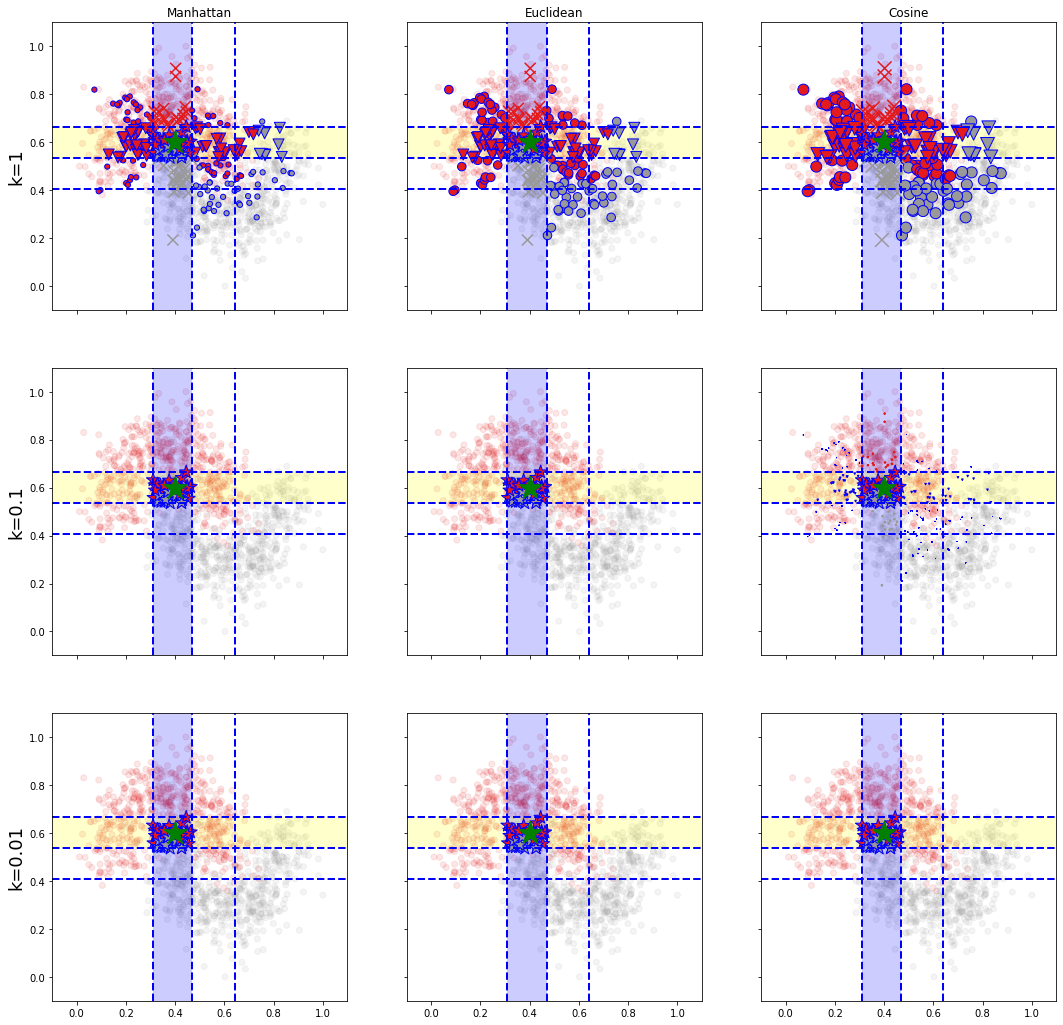

In [38]:
fig, axs = plt.subplots(3, 3, figsize=(18, 18), sharex=True, sharey=True)

axs[0, 0].set_xlim(-0.1, 1.1)
axs[0, 0].set_ylim(-0.1, 1.1)

for ax in range(3):
    for ay in range(3):
        axs[ax, ay].scatter(
            moons_X[:, 0], moons_X[:, 1],
            cmap=plt.cm.Set1, c=moons_y, alpha=0.1)

axs[0, 0].set_title('Manhattan')
axs[0, 1].set_title('Euclidean')
axs[0, 2].set_title('Cosine')

for ax, name in enumerate(names_k):
    axs[ax, 0].set_ylabel('k={}'.format(name), fontsize=18)

# Plot x-axis quartiles
x_quartiles_m = q_discretiser_moons.feature_bin_boundaries.get(0)
for i in x_quartiles_m:
    for ax in range(3):
        for ay in range(3):
            axs[ax, ay].plot(
                [i, i], [-0.1, 1.1], linewidth=2, linestyle='--', c='blue')

# Plot y-axis quartiles
y_quartiles_m = q_discretiser_moons.feature_bin_boundaries.get(1)
for i in y_quartiles_m:
    for ax in range(3):
        for ay in range(3):
            axs[ax, ay].plot(
                [-0.1, 1.1], [i, i], linewidth=2, linestyle='--', c='blue')

# Plot binarisation of the x-axis
hyper_rectangle_m_x = moons_boundary_point_q_discrete[0]
if 0 < hyper_rectangle_m_x < 3:
    hyper_rectangle_m_x_min = x_quartiles_m[hyper_rectangle_m_x - 1]
    hyper_rectangle_m_x_max = x_quartiles_m[hyper_rectangle_m_x]
elif hyper_rectangle_m_x == 0:
    hyper_rectangle_m_x_min = -0.1
    hyper_rectangle_m_x_max = x_quartiles_m[hyper_rectangle_m_x]
elif hyper_rectangle_m_x == 3:
    hyper_rectangle_m_x_min = x_quartiles_m[hyper_rectangle_m_x - 1]
    hyper_rectangle_m_x_max = 1.1
for ax in range(3):
    for ay in range(3):
        axs[ax, ay].axvspan(
            hyper_rectangle_m_x_min,
            hyper_rectangle_m_x_max,
            facecolor='blue',
            alpha=0.2)

# Plot binarisation of the y-axis
hyper_rectangle_m_y = moons_boundary_point_q_discrete[1]
if 0 < hyper_rectangle_m_y < 3:
    hyper_rectangle_m_y_min = y_quartiles_m[hyper_rectangle_m_y - 1]
    hyper_rectangle_m_y_max = y_quartiles_m[hyper_rectangle_m_y]
elif hyper_rectangle_m_y == 0:
    hyper_rectangle_m_y_min = -0.1
    hyper_rectangle_m_y_max = y_quartiles_m[hyper_rectangle_m_y]
elif hyper_rectangle_m_y == 3:
    hyper_rectangle_m_y_min = y_quartiles_m[hyper_rectangle_m_y - 1]
    hyper_rectangle_m_y_max = 1.1
for ax in range(3):
    for ay in range(3):
        axs[ax, ay].axhspan(
            hyper_rectangle_m_y_min,
            hyper_rectangle_m_y_max,
            facecolor='yellow',
            alpha=0.2)

# Plot data using a unique marker for each binary encoding
moons_unique_binary = np.unique(moons_mixup_sample_close_q_binary, axis=0)
for rep in moons_unique_binary:
    indices = xml_book.surrogates.get_hyperrectangle_indices(
        moons_mixup_sample_close_q_binary, rep)

    if np.array_equal(rep, [1, 1]):
        marker = '*'
    elif np.array_equal(rep, [1, 0]):
        marker = 'x'
    elif np.array_equal(rep, [0, 1]):
        marker = 'v'
    else:
        marker = 'o'

    for ax, k in enumerate(names_k):
        sim = manhattan_k[k][indices]
        axs[ax, 0].scatter(
            moons_mixup_sample_close[indices, 0],
            moons_mixup_sample_close[indices, 1],
            c=moons_mixup_sample_close_crisp[indices],
            cmap=plt.cm.Set1,
            marker=marker,
            edgecolors='b',
            s=200 * sim)

    for ax, k in enumerate(names_k):
        sim = euclidean_k[k][indices]
        axs[ax, 1].scatter(
            moons_mixup_sample_close[indices, 0],
            moons_mixup_sample_close[indices, 1],
            c=moons_mixup_sample_close_crisp[indices],
            cmap=plt.cm.Set1,
            marker=marker,
            edgecolors='b',
            s=200 * sim)

    for ax, k in enumerate(names_k):
        sim = cosine_k[k][indices]
        axs[ax, 2].scatter(
            moons_mixup_sample_close[indices, 0],
            moons_mixup_sample_close[indices, 1],
            c=moons_mixup_sample_close_crisp[indices],
            cmap=plt.cm.Set1,
            marker=marker,
            edgecolors='b',
            s=200 * sim)

# Plot explained instance
for ax in range(3):
    for ay in range(3):
        axs[ax, ay].scatter(
            moons_boundary_point[0], moons_boundary_point[1],
            marker='*', c='green', s=600, label='Boundary Point')

While computing the distances in each representation may have its advantages
and a clear motivation based on a particular use case, the most intuitive
behaviour comes from applying this procedure to the original data domain.

#### Explanation Sparsity ####
After deciding on the weighting strategy for the sampled instances,
the next step is to reduce the number of interpretable features
used to convey the explanation.
This may be required when the data set has a large number of
features.
We will discuss usefulness of this procedure in the next section
when talking about fitting a local linear surrogate model to
binary interpretable representations.
Contrarily, tree-based interpretable representations
(not modelled with a linear surrogate) do not require
"complexity" reduction in post-processing since they have built-in
pruning mechanisms that help to improve sparsity of their
explanations.

---

Let's first select one (out of two) binary interpretable features from the
binarisation of the quartile-based discretisation.
Next, we will select one (out of three) one-hot encoded features generated with
the tree-based discretisation (since we will later model this representation
with a linear surrogate).

As an exercise, let's select one feature with three different methods:
* [lasso path](https://fat-forensics.org/generated/fatf.utils.data.feature_selection.sklearn.lasso_path.html);
* [forward selection](https://fat-forensics.org/generated/fatf.utils.data.feature_selection.sklearn.forward_selection.html); and
* [highest weights](https://fat-forensics.org/generated/fatf.utils.data.feature_selection.sklearn.highest_weights.html).

By following the links you can read more about each approach in the
API documentation of FAT Forensics.

> Since we want to reduce the number of interpretable features, we will
  apply these functions to the binary representation created with
  quartile discretisation.

In [39]:
selection_lasso = fatf_feature_selection_skl.lasso_path(
    moons_mixup_sample_close_q_binary,
    moons_mixup_sample_close_crisp,
    features_number=1)
selection_forward = fatf_feature_selection_skl.forward_selection(
    moons_mixup_sample_close_q_binary,
    moons_mixup_sample_close_crisp,
    features_number=1)
selection_highest = fatf_feature_selection_skl.highest_weights(
    moons_mixup_sample_close_q_binary,
    moons_mixup_sample_close_crisp,
    features_number=1)

In [40]:
print('*Lasso Path* feature chosen for quartiles: {}'.format(
    selection_lasso))
print('*Forward Selection* feature chosen for quartiles: {}'.format(
    selection_forward))
print('*Highest Weights* feature chosen for quartiles: {}'.format(
    selection_highest))

*Lasso Path* feature chosen for quartiles: [1]
*Forward Selection* feature chosen for quartiles: [1]
*Highest Weights* feature chosen for quartiles: [1]


This means that all of the methods chose the **second** binary interpretable
feature (based on quartiles) as the most important, namely:
$0.54 < x_2 \leq 0.67$.
(**Index 0 corresponds to the first feature, and index 1 to the second.**)

Let's re-plot the quartile partition and binarisation to better understand
these results.
Intuitively, $0.54 < x_2 \leq 0.67$ was selected over $0.31 < x_1 \leq 0.47$
as moving outside of the *blue&yellow* region into the *blue* ($x_2$) region
is "more likely" to change the prediction of our explained instance than
doing the same for the *yellow* ($x_1$) region.

/var/folders/d0/9mvcgn8503s6975cz1p09rmc0000gn/T/ipykernel_68128/2530916095.py:25: UserWarning: You passed a edgecolor/edgecolors ('b') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(moons_mixup_sample_close[indices, 0],


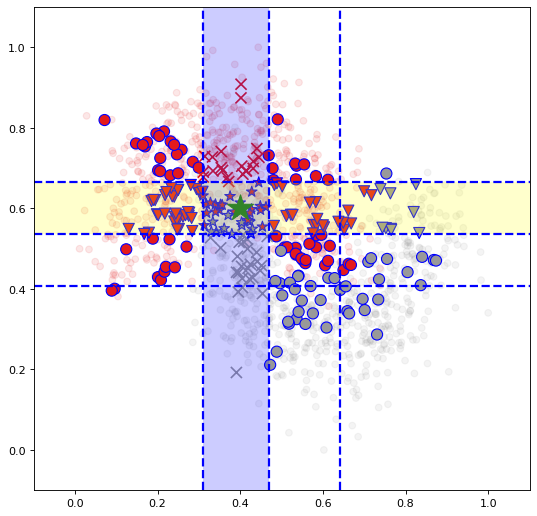

In [41]:
plt.figure(figsize=(8, 8), dpi=80)

plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)

plt.scatter(
    moons_X[:, 0], moons_X[:, 1],
    cmap=plt.cm.Set1, c=moons_y, alpha=0.1)

# Plot data using a unique marker for each binary encoding
moons_unique_binary = np.unique(moons_mixup_sample_close_q_binary, axis=0)
for rep in moons_unique_binary:
    indices = xml_book.surrogates.get_hyperrectangle_indices(
        moons_mixup_sample_close_q_binary, rep)

    if np.array_equal(rep, [1, 1]):
        marker = '*'
    elif np.array_equal(rep, [1, 0]):
        marker = 'x'
    elif np.array_equal(rep, [0, 1]):
        marker = 'v'
    else:
        marker = 'o'

    plt.scatter(moons_mixup_sample_close[indices, 0],
                moons_mixup_sample_close[indices, 1],
                c=moons_mixup_sample_close_crisp[indices],
                cmap=plt.cm.Set1,
                marker=marker,
                edgecolors='b',
                s=100)

# Plot explained instance
plt.scatter(
    moons_boundary_point[0], moons_boundary_point[1],
    marker='*', c='green', s=600, label='Boundary Point')

# Plot x-axis quartiles
x_quartiles_m = q_discretiser_moons.feature_bin_boundaries.get(0)
for i in x_quartiles_m:
    plt.plot([i, i], [-0.1, 1.1], linewidth=2, linestyle='--', c='blue')

# Plot y-axis quartiles
y_quartiles_m = q_discretiser_moons.feature_bin_boundaries.get(1)
for i in y_quartiles_m:
    plt.plot([-0.1, 1.1], [i, i], linewidth=2, linestyle='--', c='blue')

# Plot binarisation of the x-axis
hyper_rectangle_m_x = moons_boundary_point_q_discrete[0]
if 0 < hyper_rectangle_m_x < 3:
    hyper_rectangle_m_x_min = x_quartiles_m[hyper_rectangle_m_x - 1]
    hyper_rectangle_m_x_max = x_quartiles_m[hyper_rectangle_m_x]
elif hyper_rectangle_m_x == 0:
    hyper_rectangle_m_x_min = -0.1
    hyper_rectangle_m_x_max = x_quartiles_m[hyper_rectangle_m_x]
elif hyper_rectangle_m_x == 3:
    hyper_rectangle_m_x_min = x_quartiles_m[hyper_rectangle_m_x - 1]
    hyper_rectangle_m_x_max = 1.1
plt.axvspan(hyper_rectangle_m_x_min, hyper_rectangle_m_x_max,
            facecolor='blue', alpha=0.2)

# Plot binarisation of the y-axis
hyper_rectangle_m_y = moons_boundary_point_q_discrete[1]
if 0 < hyper_rectangle_m_y < 3:
    hyper_rectangle_m_y_min = y_quartiles_m[hyper_rectangle_m_y - 1]
    hyper_rectangle_m_y_max = y_quartiles_m[hyper_rectangle_m_y]
elif hyper_rectangle_m_y == 0:
    hyper_rectangle_m_y_min = -0.1
    hyper_rectangle_m_y_max = y_quartiles_m[hyper_rectangle_m_y]
elif hyper_rectangle_m_y == 3:
    hyper_rectangle_m_y_min = y_quartiles_m[hyper_rectangle_m_y - 1]
    hyper_rectangle_m_y_max = 1.1
plt.axhspan(hyper_rectangle_m_y_min, hyper_rectangle_m_y_max,
            facecolor='yellow', alpha=0.2)

Let's move on to the tree.

In [42]:
selection_lasso = fatf_feature_selection_skl.lasso_path(
    moons_mixup_sample_close_tree_binary,
    moons_mixup_sample_close_crisp,
    features_number=1)
selection_forward = fatf_feature_selection_skl.forward_selection(
    moons_mixup_sample_close_tree_binary,
    moons_mixup_sample_close_crisp,
    features_number=1)
selection_highest = fatf_feature_selection_skl.highest_weights(
    moons_mixup_sample_close_tree_binary,
    moons_mixup_sample_close_crisp,
    features_number=1)

In [43]:
print('*Lasso Path* feature chosen for one-hot tree: {}'.format(
    selection_lasso))
print('*Forward Selection* feature chosen for one-hot tree: {}'.format(
    selection_forward))
print('*Highest Weights* feature chosen for one-hot tree: {}'.format(
    selection_highest))

*Lasso Path* feature chosen for one-hot tree: [2]
*Forward Selection* feature chosen for one-hot tree: [2]
*Highest Weights* feature chosen for one-hot tree: [2]


These one-hot encoded indices need to be translated into tree node IDs
before becoming readable.
We execute a similar procedure to generating one-hot encoding of the
explained instance for tree discretisations, which we discussed above.

In [44]:
np.sort(np.unique(moons_mixup_sample_close_tree_discrete))

array([2, 3, 4])

Therefore, the most important partition of the feature space is encoded
by the tree node **#4** (item under the 2nd index in the array above).

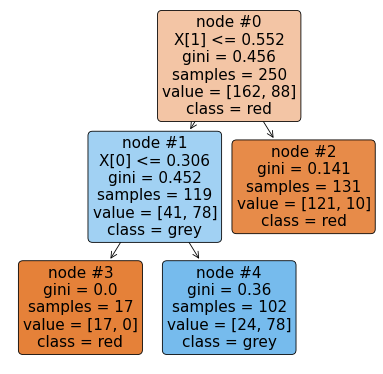

In [45]:
plt.figure(figsize=(8, 8), dpi=60)
_ = sklearn.tree.plot_tree(
    tree_binariser_moons,
    node_ids=True,
    class_names=['red', 'grey'],
    rounded=True,
    filled=True)

This means that all of the methods chose partition:
$x_2 \leq 0.55 \;\; \land \;\; x_1 > 0.31$.

This is reasonable since this partition cleanly separates the explained
instance from the grey class and
the upper partition is mostly populated by instances with identical class
predictions.
Let's re-plot the tree partition to better understand this result.

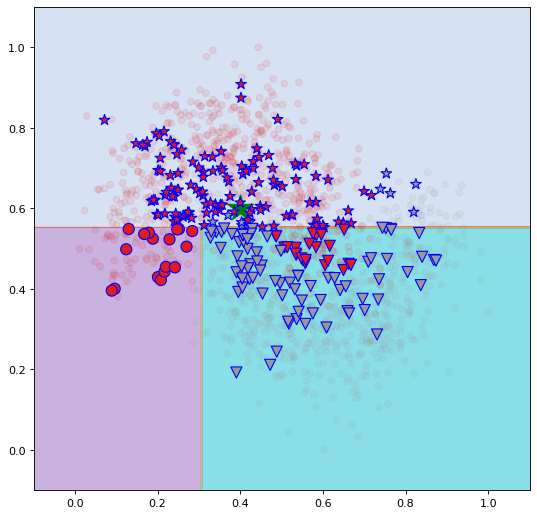

In [46]:
plt.figure(figsize=(8, 8), dpi=80)

plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)

# Compute the decision boundary of the tree
x_y_step = 0.005
x_min, x_max = -0.1, 1.1
y_min, y_max = -0.1, 1.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, x_y_step),
                     np.arange(y_min, y_max, x_y_step))

Z = tree_binariser_moons.apply(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
Z_norm = np.zeros_like(Z)
for i, v in enumerate(np.unique(Z)):
    mask = (Z == v)
    Z_norm[mask] = i

# Plot the boundary
plt.contourf(xx, yy, Z_norm, cmap=plt.cm.tab20, alpha=0.5)

# Plot data
plt.scatter(
    moons_X[:, 0], moons_X[:, 1],
    cmap=plt.cm.Set1, c=moons_y, alpha=0.1)

# Plot explained instance
plt.scatter(
    moons_boundary_point[0], moons_boundary_point[1],
    marker='*', c='green', s=600, label='Boundary Point')

# Plot data using a unique marker for each encoding
moons_unique_binary = np.unique(moons_mixup_sample_close_tree_discrete, axis=0)
markers = ['x', 'v', 'o']
for rep in moons_unique_binary:
    indices = xml_book.surrogates.get_hyperrectangle_indices(
        moons_mixup_sample_close_tree_discrete, rep)

    if np.array_equal(rep, moons_boundary_point_tree_discrete):
        marker = '*'
    else:
        marker = markers.pop()

    plt.scatter(moons_mixup_sample_close[indices, 0],
                moons_mixup_sample_close[indices, 1],
                c=moons_mixup_sample_close_crisp[indices],
                cmap=plt.cm.Set1,
                marker=marker,
                edgecolors='b',
                s=100)

#### Surrogate Model Fitting ####
Last but not least, we can fit a local surrogate model and generate an
explanation.
For this toy data set, we will **skip** the *sample weighting* and
the *selection of explainable features* -- we will come back to them when
dealing with a larger data set, i.e., *Bikes Sharing*.
Here, we will look at three approaches:
* LIME-like explainer -- fitting a sparse linear model to a binary
  representation generated from a quartile-based discretisation;
* RuleFit-like explainer -- fitting a sparse linear model to a binary
  representation generated from a tree-based discretisation
  (one-hot encoding); and
* tree-based explainer -- fitting a local decision tree directly to
  the sampled data.

> When dealing with surrogate linear models, in both cases we are fitting
  them to data that are binary, i.e., in the {0, 1} set.
  Since all of the features are within the same range, the coefficients of
  the model -- the base of our explanations -- are directly comparable.
  In case the original data representation is used with a linear model,
  all of the features have to be normalised to the same range (not necessarily
  [0, 1]) for the weights to be comparable.

##### LIME-like #####
The **only** explanation available from this explainer is the
**importance** of interpretable concepts composed by binarisation of
quartile-based discretisation.
In case of the data point that we chose to explain these concepts are
(see the *Interpretable Representation* notebook for more details):
* $0.31 < x_1 \leq 0.47$ (x-axis); and
* $0.54 < x_2 \leq 0.67$ (y-axis)

since these are the feature partitions that enclose the explained instance.

When a (sparse) linear model is fitted to this binary representation
using black-box predictions of these points as a target, it effectively learns
how important *being within a given range* is for predicting the class
assigned by the black box to our explained instance.
Let's compute these explanations for our data point.

---

Since we are using a *crisp* black box, we need to build a target vector
for our sampled data
that encodes $1$ for every prediction that is the same as the one of our
explained instance, and $0$ otherwise.

In [47]:
explanation_target_class = clf_moons_crisp.predict(
    [moons_boundary_point])[0]

explanation_targets = (
    moons_mixup_sample_close_crisp == explanation_target_class)

In [48]:
moons_lime_like = sklearn.linear_model.RidgeClassifier()
moons_lime_like.fit(
    moons_mixup_sample_close_q_binary, explanation_targets)

RidgeClassifier()

In [49]:
moons_lime_like.coef_

array([[-0.3849263 ,  0.46096981]])

We can visualise this explanation as a bar plot.

Text(0.5, 1.0, 'Red class explanation')

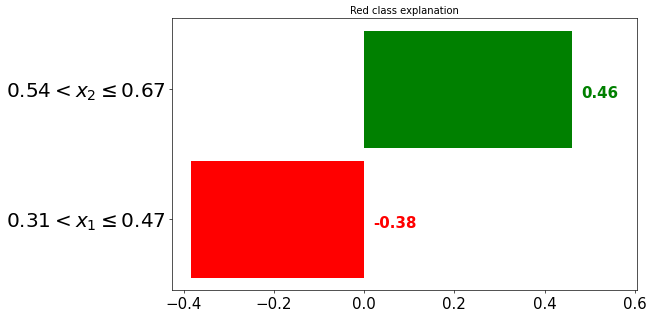

In [50]:
x_ = ['$0.31 < x_1 \leq 0.47$', '$0.54 < x_2 \leq 0.67$']
h_ = moons_lime_like.coef_[0].tolist()
c_ = ['g' if i > 0 else 'r' for i in h_]

plt.figure(figsize=(10, 6), dpi=60)

# Plot bars
plt.barh(x_, h_, color=c_, height=.9)

for i, v in enumerate(h_):
    if v > 0:
        s = v+0.02
    else:
        s = .02
    c = c_[i]
    plt.text(s, i - .06, '{:.2f}'.format(v),
             color=c, fontweight='bold', fontsize=18)

left_, right_ = plt.xlim()
plt.xlim((left_, 1.2*right_))

plt.tick_params(axis="x", labelsize=18)
plt.tick_params(axis="y", labelsize=24)

plt.title('Red class explanation')

Therefore, for predicting the red class in our binary representation:
* $0.31 < x_1 \leq 0.47$ has importance of $-0.38$; and
* $0.54 < x_2 \leq 0.67$ has importance of $0.46$.

The latter concept has high positive importance since going outside of the
$x_2$ range that it encodes -- from *yellow&blue* into *blue* -- is
likely to result in getting into a territory of the black box
where it predicts the grey class.
The $0.31 < x_1 \leq 0.47$ concept, on the other hand, has negative
importance since going outside of the *yellow&blue* into the *yellow*
region is not very likely to change the black-box prediction from red to grey.

##### RuleFit-like #####
RuleFit generates a collection of diverse (and overlapping) rules by
fitting a random forest to the explained data and extracting all of
its root-to-leaf paths as separate decision rules.
The importance of each rule for predicting the class of the explained instance
can then be learnt with a sparse linear model (akin to LIME).

---

Let's compute importance of our one-hot encoded tree-based rules.

In [51]:
moons_rulefit_like = sklearn.linear_model.RidgeClassifier()
moons_rulefit_like.fit(
    moons_mixup_sample_close_tree_binary, explanation_targets)

RidgeClassifier()

In [52]:
moons_rulefit_like.coef_

array([[ 0.41335198,  0.53755804, -0.95091002]])

We can visulaise this explanation as a bar plot.

Text(0.5, 1.0, 'Red class explanation')

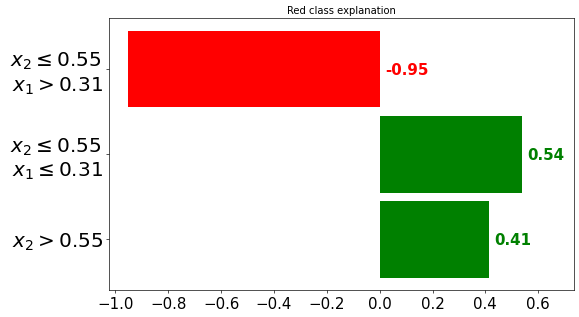

In [53]:
x_ = ['$x_2 > 0.55$',
      '$x_2 \\leq 0.55$ \n $x_1 \\leq 0.31$',
      '$x_2 \\leq 0.55$ \n $x_1 > 0.31$']
h_ = moons_rulefit_like.coef_[0].tolist()
c_ = ['g' if i > 0 else 'r' for i in h_]

plt.figure(figsize=(10, 6), dpi=60)

# Plot bars
plt.barh(x_, h_, color=c_, height=.9)

for i, v in enumerate(h_):
    if v > 0:
        s = v+0.02
    else:
        s = .02
    c = c_[i]
    plt.text(s, i - .06, '{:.2f}'.format(v),
             color=c, fontweight='bold', fontsize=18)

left_, right_ = plt.xlim()
plt.xlim((left_, 1.2*right_))

plt.tick_params(axis="x", labelsize=18)
plt.tick_params(axis="y", labelsize=24)

plt.title('Red class explanation')

In our case:
* the first rule has **0.41** importance and corresponds to tree node #2 --
  $x_2 > 0.55$;
* the second rule has **0.54** importance and corresponds to tree node #3 --
  $x_2 \leq 0.55 \;\; \land \;\; x_1 \leq 0.31$; and
* the third rule has **-0.95** importance and corresponds to tree node #4 --
  $x_2 \leq 0.55 \;\; \land \;\; x_1 > 0.31$.

These explanations are easy to interpret and very appealing in our scenario.
The first rule has high positive importance because above the $x_2 > 0.55$
threshold most of the points are predicted red by our black box.
The second rule has also high positive importance because within the region
enclosed by $x_2 \leq 0.55 \;\; \land \;\; x_1 \leq 0.31$ most of the sampled
instances are also predicted red.
Finally, the last rule has high negative importance because many points
enclosed by this region -- $x_2 \leq 0.55 \;\; \land \;\; x_1 > 0.31$ --
are predicted grey.

##### Tree-based Explainer #####
Next, we move on to our tree-based surrogate -- we simply fit a tree to
our locally sampled data.

Such a tree can provide numerous explanations:
* feature importance;
* logical rules extracted from root-to-leaf paths; and
* counterfactuals extracted by parsing the tree structure.

Let's have a look at them.

In [54]:
moons_tree_based = sklearn.tree.DecisionTreeClassifier(
    random_state=42, max_leaf_nodes=4, min_impurity_decrease=0.05)
moons_tree_based.fit(
    moons_mixup_sample_close,
    moons_mixup_sample_close_crisp)

DecisionTreeClassifier(max_leaf_nodes=4, min_impurity_decrease=0.05,
                       random_state=42)

Let's start with feature importance.

In [55]:
moons_tree_based.feature_importances_

array([0.28949132, 0.71050868])

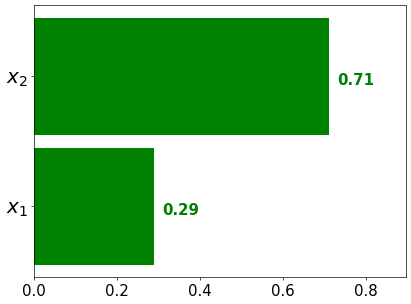

In [56]:
x_ = ['$x_1$', '$x_2$']
h_ = moons_tree_based.feature_importances_.tolist()
c_ = ['g' if i > 0 else 'r' for i in h_]

plt.figure(figsize=(8, 6), dpi=60)

# Plot bars
plt.barh(x_, h_, color=c_, height=.9)

for i, v in enumerate(h_):
    if v > 0:
        s = v+0.02
    else:
        s = .02
    c = c_[i]
    plt.text(s, i - .06, '{:.2f}'.format(v),
             color=c, fontweight='bold', fontsize=18)

left_, right_ = plt.xlim()
plt.xlim((left_, 1.2*right_))

plt.tick_params(axis="x", labelsize=18)
plt.tick_params(axis="y", labelsize=24)

Let's visualise the tree to *manually* extract the rules and counterfactuals.

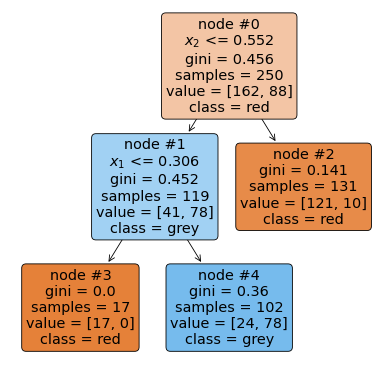

In [57]:
plt.figure(figsize=(8, 8), dpi=60)
_ = sklearn.tree.plot_tree(
    moons_tree_based,
    node_ids=True,
    class_names=['red', 'grey'],
    rounded=True,
    filled=True,
    feature_names=['$x_1$', '$x_2$'])

The **feature importance** tells us that feature $x_2$ is more than twice as
important as feature $x_1$ when separating the classes of our local data
sample.
Inspecting the plot of our sample corroborates this insight -- no single
split on the x-axis (feature $x_1$) can give as clean separation of
the classes as a split on they y-axis (feature $x_2$).

---

Since our local surrogate tree is relatively small, we can inspect it visually.
However, in more complex cases it may not be possible or can prove relatively
difficult.
To mitigate this issue, we can extract root-to-leaf paths for a selected
class and present them to the explainee as **logical rules**.
For example, there are two rules for predicting the red class in the
*neighbourhood* of the explained instance:
$$
0.55 < x_2 \;\; \Rightarrow \;\; \texttt{red}
$$
and
$$
x_2 \leq 0.55 \;\; \land \;\; x_1 \leq 0.36  \;\;
\Rightarrow \;\; \texttt{red} \; \text{.}
$$
However, the length of these rules will grow proportionally to the depth of
the surrogate tree, which may render them incomprehensible.

---

Class-contrastive counterfactual statements come to a rescue.
While it is possible to extract them algorithmically from the structure of
a decision tree, in this tutorial we will do it manually by visually
inspecting tree graphs.
Our explained instance $\mathring{x} = (0.4, 0.6)$ is assigned to node #2 of
the tree, which predicts the `red` class.
The only leaf predicting the opposite class (`grey`) is #4, yielding the
following counterfactual:

> Had the second feature of the explained data point $\mathring{x}_2 = 0.6$
  been **smaller or equal** to $0.55$, its prediction would have changed
  from `red` to `grey`.

It is a very appealing and succinct explanation that clearly conveys the local
(in the neighbourhood of the explained instance) behaviour of our black box.

Now, let's move on the the *Bikes* data set and see how our surrogate
explainers work for a more complex problem.

## Bikes Data Set ##
When dealing with the Two Moons data set, we mostly made use of a crisp
black box.
For a change, let's explain a probabilistic classifier trained on the Bikes
data set.
Again, we will explain an instance with three different approaches:
* LIME-like explainer -- fitting a sparse linear **regression** to
  a binary representation generated from a quartile-based discretisation and
  probabilities predicted by the black box for the explained class;
* RuleFit-like explainer -- fitting a sparse linear **regression** to a binary
  representation generated from a tree-based discretisation
  (one-hot encoding) and probabilities predicted by the black box for the
  explained class; and
* tree-based explainer -- fitting a local **regression** tree directly to
  the sampled data in *two* variants:
  - **classic** (single-output) regression tree fitted to the probabilities
    predicted by the black box for the explained class, and
  - **multi-output** regression tree fitted to the probabilities
    predicted by the black box for **all** of the class, thus
    modelling class interactions
    (see [here](https://arxiv.org/abs/2005.01427) for more details).

### Loading Data and Black Boxes ###
We start by loading the *Bikes Sharing* data set and
fitting two black boxes: one probabilistic and one crisp.

In [58]:
(bikes_train_X,
 bikes_test_X,
 bikes_train_y,
 bikes_test_y,
 bikes_feature_names,
 bikes_target_name) = xml_book.data.generate_bikes(random_seed=42)

bikes_target_classes = ['low', 'medium', 'high']

22-Mar-21 18:34:41 fatf         INFO     Seeding RNGs using the input parameter.


22-Mar-21 18:34:41 fatf         INFO     Seeding RNGs with 42.


In [59]:
clf_bikes_proba = xml_book.models.get_random_forest(
    bikes_train_X, bikes_train_y, random_seed=42)

22-Mar-21 18:34:45 fatf         INFO     Seeding RNGs using the input parameter.


22-Mar-21 18:34:45 fatf         INFO     Seeding RNGs with 42.


In [60]:
clf_bikes_crisp = xml_book.models.get_svc(
    bikes_train_X, bikes_train_y, random_seed=42)

22-Mar-21 18:34:45 fatf         INFO     Seeding RNGs using the input parameter.


22-Mar-21 18:34:45 fatf         INFO     Seeding RNGs with 42.


### Choosing an Instance ###
Now, we choose an instance to be explained.
We opt for a data point that our probabilistic black box model is relatively
uncertain about, which is likely to indicate its closeness to a decision
boundary.

In [61]:
bikes_test_pred_proba = clf_bikes_proba.predict_proba(bikes_test_X)

In [62]:
boundary_pred = np.square(bikes_test_pred_proba - (1 / 3)).sum(axis=1)
boundary_index = np.argmin(boundary_pred)

bikes_boundary_point = bikes_test_X[boundary_index, :]
bikes_boundary_point_proba = bikes_test_pred_proba[boundary_index, :]

print('Close Point Prediction: {}.'.format(bikes_boundary_point_proba))

Close Point Prediction: [0.2        0.45097643 0.34902357].


In [63]:
bikes_boundary_point_class_index = np.argmax(bikes_boundary_point_proba)
bikes_boundary_point_class = (
    bikes_target_classes[bikes_boundary_point_class_index])

bikes_boundary_point_class

'medium'

### Sampling Data ###
Having investigated how different samplers perform on this particular data set
(cf. `3-data-sampling.ipynb`), we opt for *Mixup* and we sample 1500 data
points in the original data domain.

Since the bikes data set contains categorical features (albeit numerically
encoded), we will use the `categorical_indices` parameter of the Mixup sampler
to ensure that values generated for these features are from within the
expected set (already existing in the data set).
For example, if a data set has an attribute that can take the values
`{0, 1, 2}`, only these values will be present in the sampled data.
The following features in the Bikes data set are categorical:
`['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']`.

In [64]:
 bikes_feature_names

['season',
 'yr',
 'mnth',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed']

In [65]:
bikes_categorical_indices = list(range(0, 7))

In [66]:
bikes_samples_number = 1500

bikes_mixup_sampler = fatf_augmentation.Mixup(
    bikes_test_X,
    bikes_test_y,
    categorical_indices=bikes_categorical_indices)

In [67]:
fatf.setup_random_seed(42)

bikes_mixup_sample_close = bikes_mixup_sampler.sample(
    bikes_boundary_point,
    samples_number=bikes_samples_number)

22-Mar-21 18:34:45 fatf         INFO     Seeding RNGs using the input parameter.


22-Mar-21 18:34:45 fatf         INFO     Seeding RNGs with 42.


In [68]:
bikes_mixup_sample_close_crisp = clf_bikes_crisp.predict(
    bikes_mixup_sample_close)

bikes_mixup_sample_close_proba = clf_bikes_proba.predict_proba(
    bikes_mixup_sample_close)

Let's investigate versatility of our sample for the explained class.

In [69]:
bikes_mixup_sample_close_proba_ex = (
    bikes_mixup_sample_close_proba[:, bikes_boundary_point_class_index])

v_min = np.min(bikes_mixup_sample_close_proba_ex)
v_max = np.max(bikes_mixup_sample_close_proba_ex)
v_mse = xml_book.surrogates.mse(bikes_mixup_sample_close_proba_ex)

In [70]:
print('Sample min: {:.3f}'.format(v_min))
print('Sample max: {:.3f}\n'.format(v_max))
print('Sample mse: {:.3f}'.format(v_mse))

Sample min: 0.024
Sample max: 0.964

Sample mse: 0.055


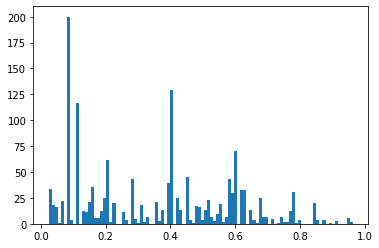

In [71]:
_ = plt.hist(bikes_mixup_sample_close_proba_ex, bins=100)

The sample seems fairly diverse, let's move on to building the explainers.

### LIME-like Explainer ###

#### Interpretable Representation ####
Let's start with a binary representation based on quartile discretisation.
We will apply quartile discretisation to the entire data set.
The `categorical_indices` argument ensures that only numerical features are
discretised.

In [72]:
bikes_q_discretiser = fatf_discretisation.QuartileDiscretiser(
    bikes_test_X,
    feature_names= bikes_feature_names,
    categorical_indices=bikes_categorical_indices)

In [73]:
bikes_mixup_sample_close_discrete = bikes_q_discretiser.discretise(
    bikes_mixup_sample_close)

In [74]:
xml_book.surrogates.weighted_purity(
    bikes_mixup_sample_close_discrete,
    bikes_mixup_sample_close_proba_ex,
    'mse')

0.014577175118340472

The purity has improved; let's have a look at binarisation.

In [75]:
bikes_boundary_point_discrete = bikes_q_discretiser.discretise(
    bikes_boundary_point)

In [76]:
bikes_mixup_sample_close_binary = fatf_transformation.dataset_row_masking(
    bikes_mixup_sample_close_discrete, bikes_boundary_point_discrete)

In [77]:
bikes_boundary_point_binary = np.ones_like(
    bikes_boundary_point_discrete, dtype=np.int8)

In [78]:
xml_book.surrogates.weighted_purity(
    bikes_mixup_sample_close_binary,
    bikes_mixup_sample_close_proba_ex,
    'mse')

0.0252348851455624

The purity of our binary interpretable representation has seen a drastic
deterioration -- the raw data sample had Mean Squared Error of 0.024,
our discretisation had 0.015, whereas the binarisation has 0.025,
which is larger than the one of the raw data.
This is not a good sign for the quality of our future explanations.
Regardless, let's move on to the explanation generation stage.

#### Explanation Generation ####
Since the Bikes data set has 11 features, we will apply both *weighting* of
sampled instances and *interpretable feature selection* steps.
Then, we will move on to fitting a sparse linear regression to the probabilities
of the explained class and generate an explanation.

##### Instance Weighting #####
Given a large number of categorical features in the Bikes data set,
we will use *Manhattan distance* and the exponential kernel with
width given by $0.75 \times \sqrt{\text{features number}}$
(formulation proposed by LIME).
We will compute the distance in the original feature space.

In [79]:
manhattan_dist = sklearn.metrics.pairwise.manhattan_distances(
    [bikes_boundary_point], bikes_mixup_sample_close)[0]

In [80]:
features_number = bikes_mixup_sample_close.shape[1]
kernel_width = np.sqrt(features_number) * 0.75

In [81]:
manhattan_dist_kern = fatf_kernels.exponential_kernel(
    manhattan_dist, width=kernel_width)

Interpreting the distribution is not straight forward, but let's plot
it anyway.

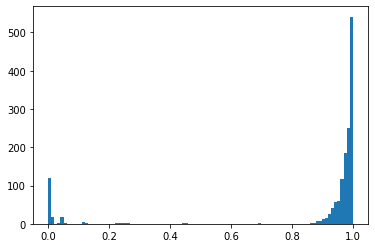

In [82]:
_ = plt.hist(manhattan_dist_kern, bins=100)

##### Interpretable Feature Selection #####
Since we are dealing with 11 features, let's select 4 of them to
introduce sparsity into our explanation.

In [83]:
selection_lasso = fatf_feature_selection_skl.lasso_path(
    bikes_mixup_sample_close_binary,
    bikes_mixup_sample_close_proba_ex,
    features_number=4)
selection_forward = fatf_feature_selection_skl.forward_selection(
    bikes_mixup_sample_close_binary,
    bikes_mixup_sample_close_proba_ex,
    features_number=4)
selection_highest = fatf_feature_selection_skl.highest_weights(
    bikes_mixup_sample_close_binary,
    bikes_mixup_sample_close_proba_ex,
    features_number=4)

In [84]:
print('*Lasso Path* features chosen for quartiles: {}'.format(
    selection_lasso))
print('*Forward Selection* features chosen for quartiles: {}'.format(
    selection_forward))
print('*Highest Weights* features chosen for quartiles: {}'.format(
    selection_highest))

*Lasso Path* features chosen for quartiles: [ 1  7  9 10]
*Forward Selection* features chosen for quartiles: [ 1  7  9 10]
*Highest Weights* features chosen for quartiles: [ 1  7  9 10]


All of the methods seem to agree -- we do not need to make a call here.
Finally, let's move on to explanation generation.

##### Explanation Generation #####
We train Ridge regression on the selected subset of interpretable features
for the probabilities predicted by the black box on the sampled data
for our explained class,
using the kernelised Manhattan distances as sample weights.

In [85]:
bikes_lime_like = sklearn.linear_model.Ridge()
bikes_lime_like.fit(
    bikes_mixup_sample_close_binary[:, selection_lasso],
    bikes_mixup_sample_close_proba_ex,
    sample_weight=manhattan_dist_kern)

Ridge()

Let's generate the names of our interpretable features...  
(we extract the names of binary interpretable features for
numerical attributes (numerical bins) from the
`feature_value_names` attribute of the quartile discretiser
object, and build names of interpretable features for the
categorical attributes manually)

In [86]:
interpretable_feature_names = []
for feature_index in selection_lasso:
    feature_index = feature_index.astype(int)
    bin_id = bikes_boundary_point_discrete[feature_index].astype(int)

    # Generate interpretable representation names of categorical attributes
    if feature_index in bikes_categorical_indices:
        interpretable_feature_name = '{} = {}'.format(
            bikes_feature_names[feature_index], bin_id)
    # Generate interpretable representation names of numerical attributes
    else:
        interpretable_feature_name = (
            bikes_q_discretiser.feature_value_names[feature_index][bin_id])

    interpretable_feature_names.append(interpretable_feature_name)

interpretable_feature_names

['yr = 1', '0.50 < *temp* <= 0.66', '0.73 < *hum*', '0.23 < *windspeed*']

...and plot the explanations.

Text(0.5, 1.0, '*medium* class explanation')

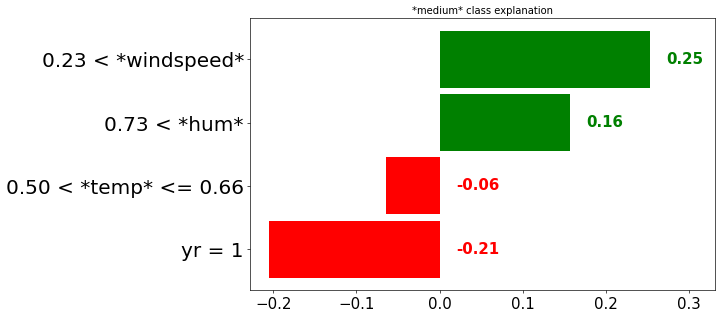

In [87]:
x_ = interpretable_feature_names
h_ = bikes_lime_like.coef_.tolist()
c_ = ['g' if i > 0 else 'r' for i in h_]

plt.figure(figsize=(10, 6), dpi=60)

# Plot bars
plt.barh(x_, h_, color=c_, height=.9)

for i, v in enumerate(h_):
    if v > 0:
        s = v+0.02
    else:
        s = .02
    c = c_[i]
    plt.text(s, i - .06, '{:.2f}'.format(v),
             color=c, fontweight='bold', fontsize=18)

left_, right_ = plt.xlim()
plt.xlim((left_, 1.2*right_))

plt.tick_params(axis="x", labelsize=18)
plt.tick_params(axis="y", labelsize=24)

plt.title('*{}* class explanation'.format(bikes_boundary_point_class))

Therefore, **for this particular instance** the *windspeed* larger than 0.23
has significant positive influence on predicting the **medium** class.
*humidity* larger than 0.73 also has positive effect, whereas *temp*erature
between 0.5 and 0.66 and the year being of category 1 have negative effects.
By looking at the
[description](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset)
of the Bikes data set, $yr = 1$ is 2012 and the temperature is between
15.5 and 23.02 degree Celsius.

### RuleFit-like Explainer ###

#### Tree-based Interpretable Representation ####
We start by creating a tree-based discretisation of the feature space.

In [88]:
tree_binariser_bikes = sklearn.tree.DecisionTreeRegressor(
    random_state=42, max_depth=3)
tree_binariser_bikes.fit(bikes_mixup_sample_close,
                         bikes_mixup_sample_close_proba_ex)

DecisionTreeRegressor(max_depth=3, random_state=42)

First, we get the discrete...

In [89]:
bikes_mixup_sample_close_tree_discrete = tree_binariser_bikes.apply(
    bikes_mixup_sample_close)
bikes_boundary_point_tree_discrete = tree_binariser_bikes.apply(
    [bikes_boundary_point])[0]  # scikit-learn only accepts 2-D data

...then binary (one-hot encoded) representation.

In [90]:
bikes_mixup_sample_close_tree_binary = xml_book.surrogates.one_hot_encode(
    bikes_mixup_sample_close_tree_discrete)

Let's see purity of out discretisation.

In [91]:
xml_book.surrogates.weighted_purity(
    bikes_mixup_sample_close_tree_binary,
    bikes_mixup_sample_close_proba_ex,
    'mse')

0.023009279041967014

We have not seen much of an improvement in the purity of our discretisation
because we limited the tree depth to 3.
This is because we need to visually inspect the tree to extract important
rules, however if this step is processed algorithmically, we can increase the
tree depth to get better quality discretisation.

#### Explanation Generation ####

In [92]:
bikes_rulefit_like = sklearn.linear_model.Ridge()
bikes_rulefit_like.fit(
    bikes_mixup_sample_close_tree_binary,
    bikes_mixup_sample_close_proba_ex,
    sample_weight=manhattan_dist_kern)

Ridge()

In [93]:
bikes_rulefit_like.coef_

array([-0.12464442,  0.1292043 ,  0.10902876, -0.33209851, -0.11180737,
        0.07220614,  0.20656718,  0.05154393])

Let's find the four most significant rules.

In [94]:
important_one_hot = np.argsort(np.abs(bikes_rulefit_like.coef_))[::-1]
important_one_hot = important_one_hot[:4]
important_one_hot

array([3, 6, 1, 0])

Let's figure out which tree nodes they correspond to --
we repeat the same procedure as with the Two Moons data set.

In [95]:
leaf_id = np.sort(np.unique(bikes_mixup_sample_close_tree_discrete))
important_leaves = leaf_id[important_one_hot]
important_leaves

array([ 7, 13,  4,  3])

Next, we visualise the tree to find the rules.
The value predicted by the tree is probability of the *middle* class.

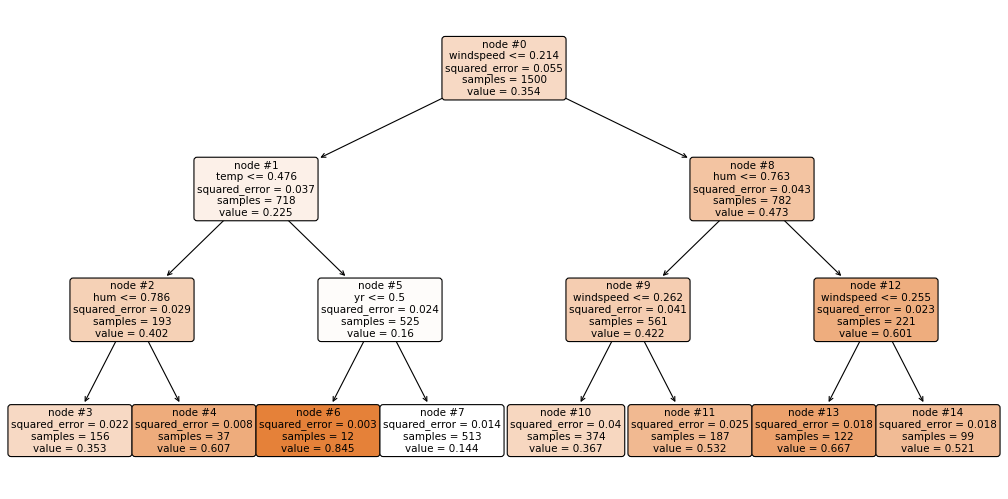

In [96]:
plt.figure(figsize=(16, 8), dpi=80)
_ = sklearn.tree.plot_tree(
    tree_binariser_bikes,
    node_ids=True,
    class_names=bikes_target_classes,
    rounded=True,
    filled=True,
    feature_names=bikes_feature_names)

We can visualise this explanation as a bar plot.

Text(0.5, 1.0, '*medium* class explanation')

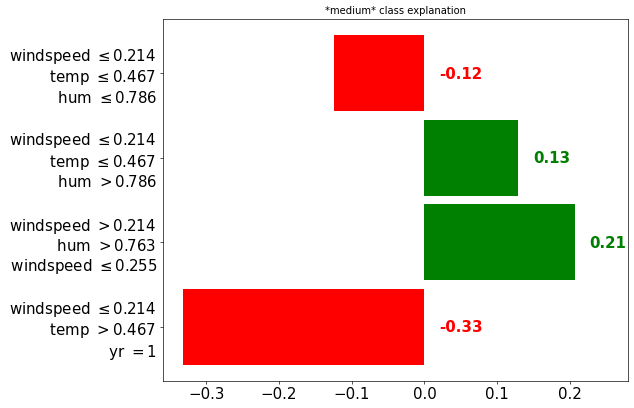

In [97]:
x_ = ['windspeed $\leq 0.214$ \n temp $> 0.467$ \n yr $=1$',
      'windspeed $> 0.214$ \n hum $> 0.763$ \n windspeed $\leq 0.255$',
      'windspeed $\leq 0.214$ \n temp $\leq 0.467$ \n hum $> 0.786$',
      'windspeed $\leq 0.214$ \n temp $\leq 0.467$ \n hum $\leq 0.786$']
h_ = bikes_rulefit_like.coef_[important_one_hot].tolist()
c_ = ['g' if i > 0 else 'r' for i in h_]

plt.figure(figsize=(10, 8), dpi=60)

# Plot bars
plt.barh(x_, h_, color=c_, height=.9)

for i, v in enumerate(h_):
    if v > 0:
        s = v+0.02
    else:
        s = .02
    c = c_[i]
    plt.text(s, i - .06, '{:.2f}'.format(v),
             color=c, fontweight='bold', fontsize=18)

left_, right_ = plt.xlim()
plt.xlim((left_, 1.2*right_))

plt.tick_params(axis="x", labelsize=18)
plt.tick_params(axis="y", labelsize=18)

plt.title('*{}* class explanation'.format(bikes_boundary_point_class))

The top two rules tell us that with *windspeed* $\leq 0.214$ and *temperature*
$\leq 0.467$, the humidity is a deciding factor for predicting the *medium*
class:
* *humidity* $> 0.786$ has positive effect on this class, and
* *humidity* $\leq 0.786$ has negative effect.

Similarly, for *windspeed* between $0.214$ and $0.255$, *humidity* higher than
$0.763$ has a positive effect on predicting the *medium* class.

The last rule tells us that for low *windspeed* ($\leq 0.214$) and high
*temperature* ($> 0.467$), the year is a deciding factor.

While these explanations are a bit more intuitive, it is difficult to tell
whether the effect would push the prediction down to *low* or up to *high*.
Let's see whether decision tree-based surrogates can help us with that.

### Tree-based Local Surrogate ###

#### Single-output Regression Surrogate ####
Let's start with a simple regression tree trained on the
sampled data.

In [98]:
tree_based_surrogate_single = sklearn.tree.DecisionTreeRegressor(
    random_state=42, max_depth=3)
tree_based_surrogate_single.fit(
    bikes_mixup_sample_close,
    bikes_mixup_sample_close_proba_ex,
    sample_weight=manhattan_dist_kern)

DecisionTreeRegressor(max_depth=3, random_state=42)

In [99]:
tree_discretisation = tree_based_surrogate_single.apply(
    bikes_mixup_sample_close)

xml_book.surrogates.weighted_purity(
    tree_discretisation,
    bikes_mixup_sample_close_proba_ex,
    'mse')

0.025292846388453673

In [100]:
tree_based_surrogate_single.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.19107699, 0.        , 0.22998904,
       0.57893397])

In [101]:
important_features = np.argsort(
    tree_based_surrogate_single.feature_importances_)[::-1]
important_features = important_features[:3]
important_features

array([10,  9,  7])

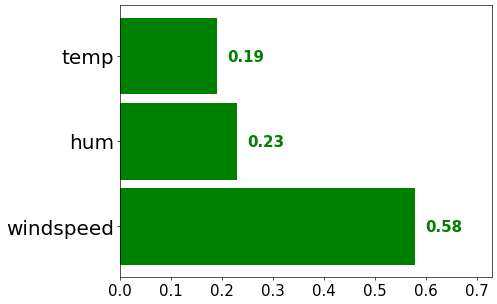

In [102]:
x_ = np.asarray(bikes_feature_names)[important_features]
h_ = tree_based_surrogate_single.feature_importances_[important_features].tolist()
c_ = ['g' if i > 0 else 'r' for i in h_]

plt.figure(figsize=(8, 6), dpi=60)

# Plot bars
plt.barh(x_, h_, color=c_, height=.9)

for i, v in enumerate(h_):
    if v > 0:
        s = v+0.02
    else:
        s = .02
    c = c_[i]
    plt.text(s, i - .06, '{:.2f}'.format(v),
             color=c, fontweight='bold', fontsize=18)

left_, right_ = plt.xlim()
plt.xlim((left_, 1.2*right_))

plt.tick_params(axis="x", labelsize=18)
plt.tick_params(axis="y", labelsize=24)

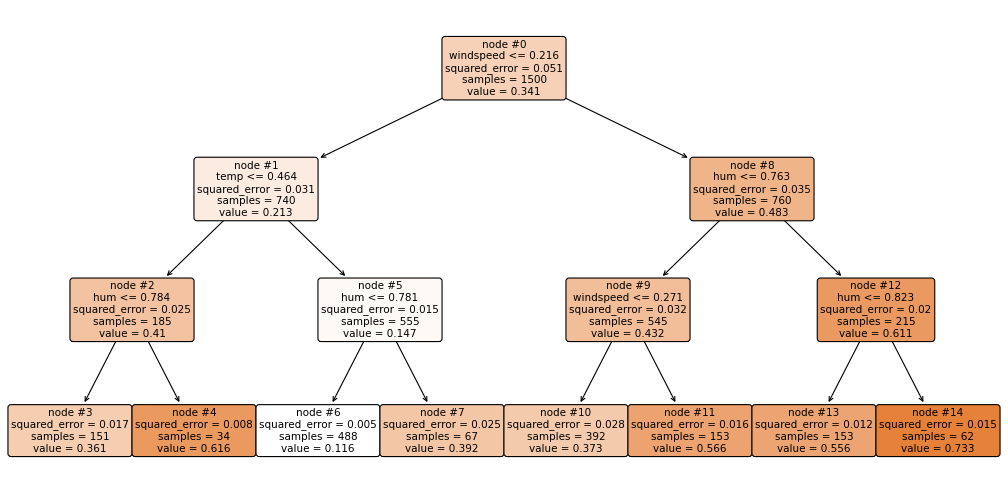

In [103]:
plt.figure(figsize=(16, 8), dpi=80)
_ = sklearn.tree.plot_tree(
    tree_based_surrogate_single,
    node_ids=True,
    class_names=bikes_target_classes,
    rounded=True,
    filled=True,
    feature_names=bikes_feature_names)

In [104]:
bikes_feature_names

['season',
 'yr',
 'mnth',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed']

In [105]:
bikes_boundary_point

array([3.      , 1.      , 9.      , 0.      , 6.      , 0.      ,
       2.      , 0.659167, 0.611121, 0.799167, 0.281104], dtype=float32)

In [106]:
tree_based_surrogate_single.apply(
    [bikes_boundary_point])[0]

13

Similar to the Moons example, we can extract counterfactuals for our explained
instance.
Since it is assigned to the leaf #13, the closest leaf with low probability
of the *medium* class is #10, which gives the following counterfactual:

> Had the *humidity* been $\leq 0.763$ instead of 0.799, and *windspeed* been
  $\leq 0.271$ instead of 0.281, the prediction of the *middle* class would
  drop from 0.556 to 0.373.

and

> Had the *humidity* been $> 0.823$ instead of 0.799, the prediction of the
  *middle* class would raise from 0.556 to 0.733.

However, we still don't know what happens to the other two classes.
Let's turn to multi-output regression trees and see how they can handle
this problem.

#### Multi-output Regression Surrogate ####
Instead of just using the probabilities predicted by the black box for the
*middle* class, we use probabilities predicted for all the classes.

In [107]:
tree_based_surrogate_multi = sklearn.tree.DecisionTreeRegressor(
    random_state=42, max_depth=3)
tree_based_surrogate_multi.fit(
    bikes_mixup_sample_close,
    bikes_mixup_sample_close_proba,
    sample_weight=manhattan_dist_kern)

DecisionTreeRegressor(max_depth=3, random_state=42)

Let's see purity of the *middle* class.

In [108]:
tree_discretisation = tree_based_surrogate_multi.apply(
    bikes_mixup_sample_close)

# Purity of the *middle* class
xml_book.surrogates.weighted_purity(
    tree_discretisation,
    bikes_mixup_sample_close_proba_ex,
    'mse')

0.02640628492253447

Also, let's have a look at purity of the *low* class...

In [109]:
# Purity of the *low* class
xml_book.surrogates.weighted_purity(
    tree_discretisation,
    bikes_mixup_sample_close_proba[:, 0],
    'mse')

0.015252539380466468

...and the *high* class.

In [110]:
# Purity of the *high* class
xml_book.surrogates.weighted_purity(
    tree_discretisation,
    bikes_mixup_sample_close_proba[:, 2],
    'mse')

0.03408769588399393

In [111]:
tree_based_surrogate_multi.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.03564297, 0.4555767 , 0.23755485,
       0.27122548])

In [112]:
important_features = np.argsort(
    tree_based_surrogate_multi.feature_importances_)[::-1]
important_features = important_features[:4]
important_features

array([ 8, 10,  9,  7])

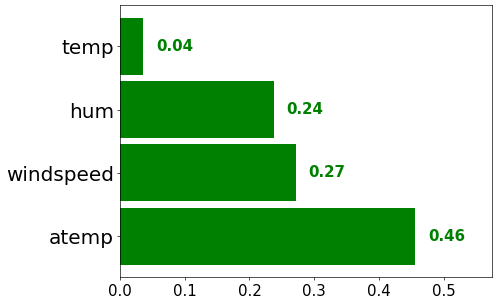

In [113]:
x_ = np.asarray(bikes_feature_names)[important_features]
h_ = tree_based_surrogate_multi.feature_importances_[important_features].tolist()
c_ = ['g' if i > 0 else 'r' for i in h_]

plt.figure(figsize=(8, 6), dpi=60)

# Plot bars
plt.barh(x_, h_, color=c_, height=.9)

for i, v in enumerate(h_):
    if v > 0:
        s = v+0.02
    else:
        s = .02
    c = c_[i]
    plt.text(s, i - .06, '{:.2f}'.format(v),
             color=c, fontweight='bold', fontsize=18)

left_, right_ = plt.xlim()
plt.xlim((left_, 1.2*right_))

plt.tick_params(axis="x", labelsize=18)
plt.tick_params(axis="y", labelsize=24)

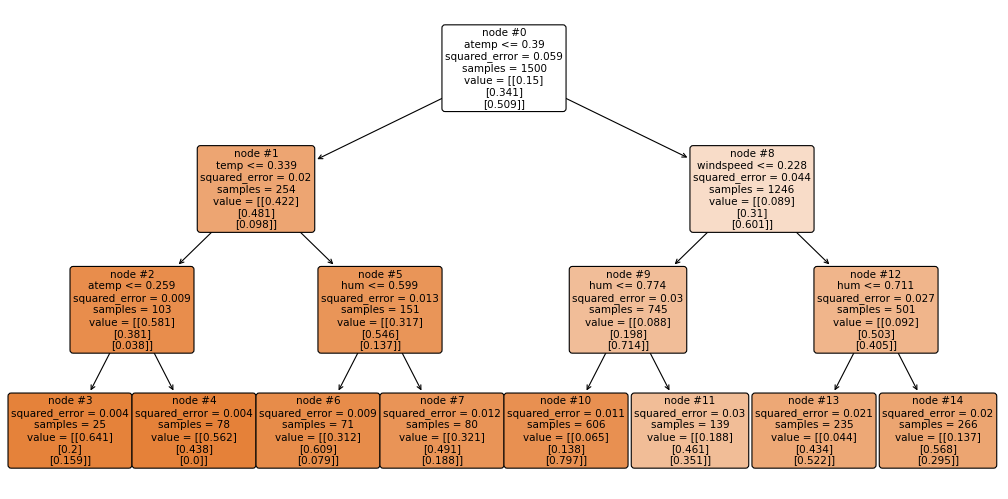

In [114]:
plt.figure(figsize=(16, 8), dpi=80)
_ = sklearn.tree.plot_tree(
    tree_based_surrogate_multi,
    node_ids=True,
    class_names=bikes_target_classes,
    rounded=True,
    filled=True,
    feature_names=bikes_feature_names)

In [115]:
bikes_feature_names

['season',
 'yr',
 'mnth',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed']

In [116]:
bikes_boundary_point

array([3.      , 1.      , 9.      , 0.      , 6.      , 0.      ,
       2.      , 0.659167, 0.611121, 0.799167, 0.281104], dtype=float32)

Let's see which tree node our instance is assigned to.

In [117]:
tree_based_surrogate_multi.apply(
    [bikes_boundary_point])[0]

14

Now, we can compose counterfactuals such as:

> Had the *humidity* been $ \leq 0.711$ instead of 0.799, the prediction would
  have changed from: **medium** -- $p(\text{medium})=0.568$, $p(\text{high})=0.295$ -- to
  **high** -- $p(\text{medium})=0.434$, $p(\text{high})=0.522$.

or

> Had *windspeed* been $\leq 0.228$ instead of 0.281, and *humidity* been
  $\leq 0.774$ instead of 0.799, the prediction would have changed from
  **medium** -- $p(\text{medium})=0.568$, $p(\text{high})=0.295$ -- to **high**
  -- $p(\text{medium})=0.138$, $p(\text{high})=0.797$.

or

> Had *atemp* been $\leq 0.39$ instead of 0.611, and *temp* been
  $\leq 0.339$ instead of 0.659, the prediction would have changed from
  **medium** -- $p(\text{medium})=0.568$, $p(\text{low})=0.137$ -- to **low**
  -- $p(\text{medium})=0.381$, $p(\text{low})=0.581$.
  (This is tree node #2, which is not a leaf node, however by looking at the
  predictions of both its children, we can safely make such a claim.)

## Summary ##
### Ready-made Explainers ###
Building bespoke surrogates is both fun and challenging.
To cater a non-technical audience, FAT Forensics implements pre-made surrogates
in addition to implementing their core building blocks.
At the moment, two such explainers are available. 

#### TabularBlimeyLime ####
This is an implementation of the popular LIME algorithm inside of the
FAT Forensics package.
This algorithm involves discretising the data using
`fatf.utils.data.discretisation.QuartileDiscretiser` and
sampling around a query data point within the discrete representation
with `fatf.utils.data.augmentation.NormalSampling`.
The sampled data is then transformed into a binary interpretable representation
where the interpretable features for the sampled data are 1 if they lie in
the same quartile (or category for categorical attributes) as the query point, else 0.
A weighted ridge regressor is then fitted to the interpretable representation
with the aim of predicting the probabilities of a selected (explained)
class output by the black-box model for the local sample.
The coefficients of this regressor are then used as interpretable
feature importance (explanations).

This implementation is limited to probabilistic black boxes.
For a more in depth description please see the documentation of this class
[here](https://fat-forensics.org/generated/fatf.transparency.predictions.surrogate_explainers.TabularBlimeyLime.html).

#### TabularBlimeyTree ####
This is a surrogate explainer based on a decision tree.
This explainer does not use an interpretable representation, instead the local
decision tree learns one.
In this case, data augmentation is done with
`fatf.utils.data.augmentation.Mixup` and the data are no discretised beforehand.
Data are augmented around a query point and a regression tree is fitted to the
probabilities of a selected (explained) class output by the black-box model
for the local sample.

At the moment, the only two available explanations are tree-based feature
importance and tree structure visualisation; counterfactuals and rules are
coming soon.
For a more in depth description please see the documentation for this class
[here](https://fat-forensics.org/generated/fatf.transparency.predictions.surrogate_explainers.TabularBlimeyTree.html).

### Final Remarks ###
We've covered quite a lot of ground.
While the steps required to extract visually appealing explanations from
local surrogates may have been complicated, we are currently developing
relevant algorithms within the FAT Forensics package to address this issue.
In particular, we are implementing more streamlined explanatory mechanisms
for scikit-learn decision trees.

You may have hoped for a secret recipe for building surrogates -- we're sorry
to disappoint you.
There is no single magical combination -- a silver bullet -- and you simply
need to adapt the composition of your surrogate explainer to the problem at
hand.
However, there are some general rules.
For example, when sampling in the binary or discrete interpretable domains,
the augmented data will be **global** and not local.
In such a case, instance weighting based on kernelised distances is
**strongly recommend**, but then you need to choose the distance metric,
kernel and its parameterisation.
With an inherently local sample, the latter step is not required but may be
helpful.
Another example is tree-specific: it may be desirable to overfit the local
surrogate tree to the data sampled in the explained neighbourhood
(vicinity of the explained instance)
to achieve an arbitrarily good fidelity with respect to our sample.
All in all, you need to choose wisely.

Now, if you choose to do so, it is time for you to build your own bespoke
surrogate explainer.
A more concise story of building custom surrogate explainers of tabular data
is available as a how-to guide on FAT Forensics' website
[here](https://fat-forensics.org/how_to/transparency/tabular-surrogates.html).
Most of the code from this guide has been ported into the
`0-environment-test.ipynb` notebook, which we used at the beginning to test
the environment.